*Antonio Coín Castro*     


# Bayesian Functional Linear Regression

In [1]:
# -- Libraries

import os
import pickle
import sys

import arviz as az
import numpy as np
import pandas as pd
import skfda

from IPython.display import display
from matplotlib import pyplot as plt
from skfda.preprocessing.smoothing import BasisSmoother
from skfda.preprocessing.smoothing.kernel_smoothers import \
    NadarayaWatsonSmoother as NW
from skfda.representation.basis import BSpline, Fourier
from skfda.representation.grid import FDataGrid
from sklearn.model_selection import KFold, train_test_split

sys.path.append("bfr/")

import bayesian_model
import plot_utils
import preprocessing
import simulation
import utils

from _fpls import FPLSBasis
from mle import compute_mle

/tmp/tmpto5yszpr/source.c:1:10: error fatal: cblas.h: No existe el fichero o el directorio
    1 | #include <cblas.h>
      |          ^~~~~~~~~
compilación terminada.


In [2]:
# -- Configuration

# Extensions
%load_ext autoreload
%autoreload 2

# Plotting configuration
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
plt.rcParams['figure.figsize'] = [6, 4]
plt.style.use('arviz-darkgrid')
NCOLS = 3


def NROWS(x, ncols=NCOLS):
    return np.ceil(x/ncols).astype('int')


# Randomness and reproducibility
SEED = 42
np.random.seed(SEED)
rng = np.random.default_rng(SEED)

# Floating point precision for display
np.set_printoptions(precision=3, suppress=True)
pd.set_option("display.precision", 3)
pd.set_option("styler.format.precision", 3)

# Multiprocessing
N_CORES = 4

# Ignore warnings
np.seterr(over='ignore', divide='ignore')
os.environ["PYTHONWARNINGS"] = 'ignore::UserWarning'

We consider the model

$$
Y = \alpha_0 + \Psi^{-1}_{X}(\alpha) + \varepsilon,
$$

i.e.,

$$
Y_i\mid X_i=x_i \sim \mathcal N\left(\alpha_0 + \sum_{j=1}^p \beta_jx_i(\tau_j), \ \sigma^2\right).
$$

The prior distributions we choose are:

\begin{align*}
  \pi(\alpha_0, \sigma^2)              & \propto 1/\sigma^2,                                                     \\
  \tau                     & \sim \mathscr U([0, 1]^p),                                              \\
  \beta\mid \tau, \sigma^2 & \sim \mathcal N\left(b_0, g\sigma^2\left[\mathcal X_\tau' \mathcal X_\tau + \eta \lambda_{\text{max}}(\mathcal X_\tau' \mathcal X_\tau)I\right]^{-1}\right),
\end{align*}

Note that for computational reasons we will work with $\log \sigma$ instead of $\sigma^2$, and hence the associated prior distribution is

$$
\pi(\alpha_0, \log\sigma) \propto 1.
$$

Writing the parameter vector as $\theta = (\beta, \tau, \alpha_0, \log\sigma)$, the joint posterior probability is:

$$
\pi(\beta, \tau, \alpha_0, \log\sigma\mid Y) \propto \frac{|G_\tau|^{1/2}}{\sigma^{p+n}} \exp\left\{ -\frac{1}{2\sigma^2} \left(\|Y- \alpha_0\boldsymbol{1} - \mathcal X_\tau\beta\|^2 + \frac{1}{g}(\beta - b_0)'G_\tau(\beta - b_0) \right) \right\}.
$$

Hence, the log-posterior probability is:

$$
\log \pi(\beta, \tau, \alpha_0, \log\sigma\mid Y) \propto \frac{1}{2}\log |G_\tau| - (p+n)\log \sigma -\frac{1}{2\sigma^2} \left(\|Y-\alpha_0\boldsymbol{1} - \mathcal X_\tau\beta\|^2 + \frac{1}{g}(\beta - b_0)'G_\tau(\beta - b_0) \right).  
$$



The metrics considered for model evaluation will be:

- RMSE.
- $R^2$.

## Example dataset

We generate a toy dataset with $n=100$ functional regressors $X_i(t) \sim GP(0, K(s, t))$, a response variable given by either a $L^2$ model or a "simple" RKHS function, a value of $\alpha_0=5$ and a variance of $\sigma^2=0.5$. More precisely, we choose one of

$$
Y_i \sim \mathcal N\big(5 -5X_i(0.1) + 10X_i(0.8), \ 0.5\big)
$$

or

$$
Y_i \sim \mathcal N\left(5 + \int_0^1 \beta(t)X_i(t)\, dt, \ 0.5\right),
$$

where $\beta \in L^2[0, 1]$.

We consider a regular grid of $N=100$ points on $[0, 1]$. In addition, we center the $X_i$ so that they have zero mean when fed to the sampling algorithms.

We also generate a test dataset with $n_{\text{test}}=50$ regressors for model evaluation.

In [3]:
# -- Data generation parameters

SYNTHETIC_DATA = True
MODEL_GEN = "RKHS"  # 'L2' or 'RKHS'
REAL_DATA = "Moisture"

INITIAL_SMOOTHING = None  # None, 'NW' or 'Basis'
N_BASIS = 16
SCALE_PREDICTORS = False
STANDARDIZE_RESPONSE = False

kernel_fn = simulation.fractional_brownian_kernel
basis = BSpline(n_basis=N_BASIS)
smoothing_params = np.logspace(-4, 4, 50)

n_train, n_test = 100, 50
N = 100
tau_range = (0, 1)

In [4]:
# -- Dataset generation

if SYNTHETIC_DATA:
    grid = np.linspace(tau_range[0] + 1./N, tau_range[1], N)
    alpha0_true = 5.
    sigma2_true = 0.5

    if MODEL_GEN == "L2":
        beta_coef = simulation.cholaquidis_scenario3
        x, y = simulation.generate_gp_l2_dataset(
            grid,
            kernel_fn,
            n_train + n_test,
            beta_coef,
            alpha0_true,
            sigma2_true,
            rng=rng
        )
    elif MODEL_GEN == "RKHS":
        beta_true = [-5., 10.]
        tau_true = [0.1, 0.8]
        x, y = simulation.generate_gp_rkhs_dataset(
            grid,
            kernel_fn,
            n_train + n_test,
            beta_true,
            tau_true,
            alpha0_true,
            sigma2_true,
            rng=rng
        )
    else:
        raise ValueError("Invalid model generation strategy.")

    # Train/test split
    X, X_test, Y, Y_test = train_test_split(
        x, y, train_size=n_train, random_state=SEED)

    # Create FData object
    X_fd = skfda.FDataGrid(X, grid)
    X_test_fd = skfda.FDataGrid(X_test, grid)

else:  # Real data
    if REAL_DATA == "Tecator":
        x, y = skfda.datasets.fetch_tecator(return_X_y=True)
        y = y[:, 1]  # Fat level
    elif REAL_DATA == "Moisture":
        data = skfda.datasets.fetch_cran(
            "Moisturespectrum", "fds")["Moisturespectrum"]
        y = skfda.datasets.fetch_cran(
            "Moisturevalues", "fds")["Moisturevalues"]
        x = FDataGrid(data["y"].T[:, ::4], data["x"][::4])
    else:
        raise ValueError("REAL_DATA must be 'Tecator' or 'Aemet'.")

    X_fd, X_test_fd, Y, Y_test = train_test_split(
        x, y, train_size=0.7, random_state=SEED)

    N = len(X_fd.grid_points[0])
    grid = preprocessing.normalize_grid(
        x.grid_points[0], tau_range[0], tau_range[1])
    n_train, n_test = len(X_fd.data_matrix), len(X_test_fd.data_matrix)

# Smooth data

if INITIAL_SMOOTHING is not None:
    if INITIAL_SMOOTHING == "NW":
        smoother = NW()
    elif INITIAL_SMOOTHING == "Basis":
        smoother = BasisSmoother(basis)
    else:
        raise ValueError(
            f"Expected 'NW' or 'Basis' but got {INITIAL_SMOOTHING}.")

    X_fd, best_smoother, X_test_fd = preprocessing.smooth_data(
        X_fd,
        smoother,
        smoothing_params,
        X_test_fd
    )

    print(
        "Smoother: {}".format(
            best_smoother.best_estimator_.__class__.__name__))
    print(
        "Smoothing parameter: {:.3f}".format(
            best_smoother.best_params_['smoothing_parameter']))

# Standardize data
X_fd, X_test_fd = preprocessing.standardize_predictors(
    X_fd, X_test_fd, SCALE_PREDICTORS)

if STANDARDIZE_RESPONSE:
    Y, Y_test = preprocessing.standardize_response(Y, Y_test)

# Get data matrices

X = X_fd.data_matrix.reshape(-1, N)
X_test = X_test_fd.data_matrix.reshape(-1, N)

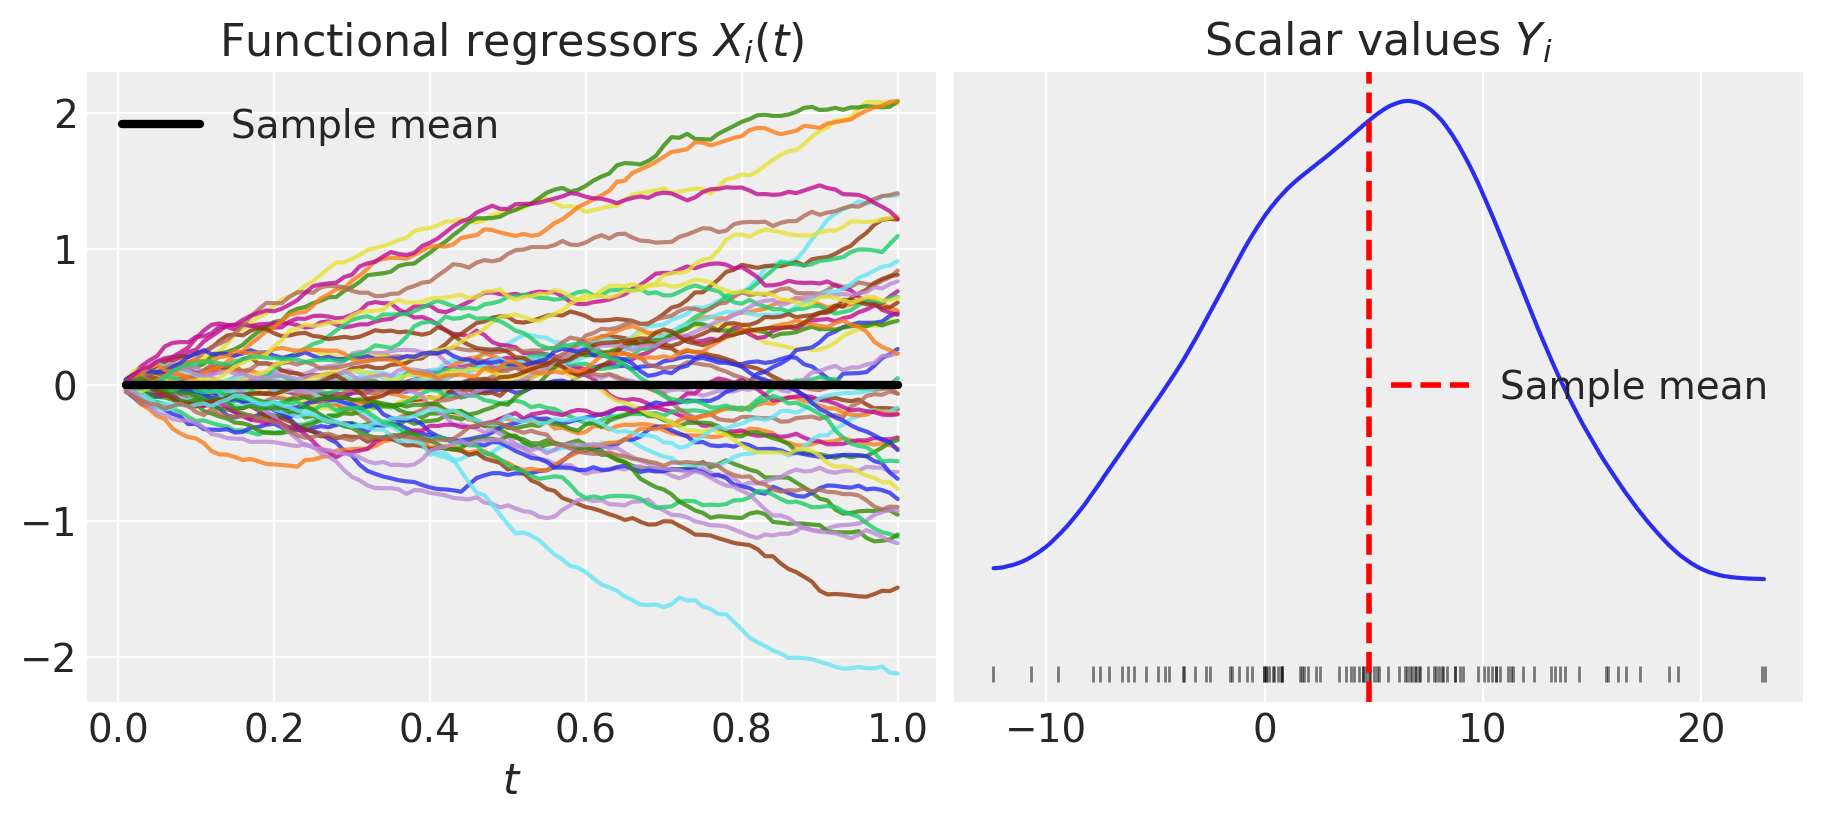

In [5]:
# -- Dataset visualization

plot_utils.plot_dataset_regression(
    X,
    Y,
    n_samples=n_train if not SYNTHETIC_DATA else n_train//2
)

## Common model hyperparameters

In our algorithms, we consider an unconstrained tranformed parameter space $\tilde \Theta=\mathbb{R}^{2\hat p+2}$ via the bijections

- $\tau_j \mapsto \operatorname{logit}(\tau_j)$.
- $\sigma^2 \mapsto \log\sigma$.

In [6]:
# -- Model hyperparameters

p_max = 3
g = 5
eta = 0.1

mle_method = 'L-BFGS-B'  # 'Nelder-Mead', 'Powell' or 'L-BFGS-B'
mle_strategy = 'global'

prior_p = {
    1: 0.10,
    2: 0.60,
    3: 0.30,
}

beta_range = (-500, 500)

INCLUDE_P = False
TRANSFORM_TAU = False
TRANSFORM_SIGMA = True
FIT_SK = False
COMPUTE_MLE = True

In [7]:
# -- Names and labels

# Names of parameters
theta_names = ["β", "τ", "α0", "σ2"]
if INCLUDE_P:
    theta_names = ["p"] + theta_names

# Grouped labels
theta_labels_grouped = [r"$\beta$", r"$\tau$", r"$\alpha_0$", r"$\sigma^2$"]
if INCLUDE_P:
    theta_labels_grouped = [r"$p$"] + theta_labels_grouped

# Individual labels
theta_labels = [] if not INCLUDE_P else [theta_labels_grouped[0]]
for i in range(p_max):
    theta_labels.append(fr"$\beta_{i + 1}$")
for i in range(p_max):
    theta_labels.append(fr"$\tau_{i + 1}$")
theta_labels.append(theta_labels_grouped[-2])
theta_labels.append(theta_labels_grouped[-1])

# Labels for Arviz
dim_name = "theta"
theta_labeller = az.labels.MapLabeller(
    var_name_map=dict(zip(theta_names[-2:], theta_labels_grouped[-2:])),
    coord_map={dim_name: dict(
        zip(np.arange(p_max), np.arange(1, p_max + 1)))}
)

In [8]:
# -- Parameter space and miscellaneous

if TRANSFORM_TAU:
    tau_ttr = bayesian_model.Logit()
else:
    tau_ttr = bayesian_model.Identity()

if TRANSFORM_SIGMA:
    sigma2_ttr = bayesian_model.LogSq()
else:
    sigma2_ttr = bayesian_model.Identity()

# Parameter space
theta_space = bayesian_model.ThetaSpace(
    p_max,
    grid,
    include_p=INCLUDE_P,
    names=theta_names,
    labels=theta_labels,
    labeller=theta_labeller,
    tau_range=tau_range,
    beta_range=beta_range,
    tau_ttr=tau_ttr,
    sigma2_ttr=sigma2_ttr
)

# Statistics for posterior predictive checks
point_estimators_bpv = [
    ("min", np.min),
    ("max", np.max),
    ("median", np.median),
    ("mean", np.mean),
    ("std", np.std)
]

# Folds for CV
folds = KFold(shuffle=True, random_state=SEED)

## Sklearn model comparison

In [9]:
# -- Select family of regressors

alphas = np.logspace(-4, 4, 20)
n_selected = [5, 10, 15, 20, 25, X.shape[1]]
n_components = [2, 3, 4, 5, 10]
n_basis_bsplines = [8, 10, 12, 14, 16]
n_basis_fourier = [3, 5, 7, 9, 11]
n_neighbors = [3, 5, 7]

basis_bspline = [BSpline(n_basis=p) for p in n_basis_bsplines]
basis_fourier = [Fourier(n_basis=p) for p in n_basis_fourier]

basis_fpls = []
for p in n_components:
    try:
        basis_fpls.append(FPLSBasis(X_fd, Y, n_basis=p))
    except ValueError:
        print(f"Can't create FPLSBasis with n_basis={p}")
        continue

params_regularizer = {"reg__alpha": alphas}
params_svm = {"reg__C": alphas,
              "reg__gamma": ['auto', 'scale']}
params_select = {"selector__p": n_selected}
params_pls = {"reg__n_components": n_components}
params_dim_red = {"dim_red__n_components": n_components}
params_basis = {"basis__basis": basis_bspline + basis_fourier}
params_basis_fpca = {"basis__n_basis": n_components}
params_basis_fpls = {"basis__basis": basis_fpls}
params_knn = {"reg__n_neighbors": n_neighbors,
              "reg__weights": ['uniform', 'distance']}
params_mrmr = {"var_sel__method": ["MID", "MIQ"],
               "var_sel__n_features_to_select": n_components}

regressors = utils.linear_regression_comparison_suite(
    params_regularizer,
    params_select,
    params_dim_red,
    params_svm,
    params_basis,
    params_pls,
    params_knn,
    random_state=SEED
)

In [10]:
# -- Fit models and show metrics

if FIT_SK:
    df_metrics_sk, reg_cv = utils.cv_sk(
        regressors,
        X_fd,
        Y,
        X_test_fd,
        Y_test,
        folds,
        kind='linear',
        n_jobs=N_CORES,
        sort_by=-2,
        verbose=True
    )
    display(df_metrics_sk.style.hide(axis="index"))

  Fitting sk_lasso...


 /home/antcc/MCD/TFM/bayesian-functional-regression/venv-bfr-py39/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning:Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 9.900e-01, tolerance: 5.415e-01
 /home/antcc/MCD/TFM/bayesian-functional-regression/venv-bfr-py39/lib/python3.9/site-packages/sklearn/cross_decomposition/_pls.py:507: FutureWarning:The attribute `coef_` will be transposed in version 1.3 to be consistent with other linear models in scikit-learn. Currently, `coef_` has a shape of (n_features, n_targets) and in the future it will have a shape of (n_targets, n_features).


  Fitting sk_pls1...
  Fitting manual_sel+sk_ridge...
  Fitting fpca+sk_ridge...
  Fitting pca+sk_ridge...
  Fitting pls+sk_ridge...
  Fitting rmh+sk_ridge...
  Fitting manual_sel+sk_svm_rbf...
  Fitting fpca+sk_svm_rbf...
  Fitting pca+sk_svm_rbf...
  Fitting pls+sk_svm_rbf...
  Fitting rmh+sk_svm_rbf...
  Fitting sk_apls...
  Fitting sk_flin_basis...
  Fitting sk_fpls1_basis...


 /home/antcc/MCD/TFM/bayesian-functional-regression/venv-bfr-py39/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:378: FitFailedWarning:
35 fits failed out of a total of 250.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
5 fits failed with the following error:
Traceback (most recent call last):
  File "/home/antcc/MCD/TFM/bayesian-functional-regression/venv-bfr-py39/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/home/antcc/MCD/TFM/bayesian-functional-regression/venv-bfr-py39/lib/python3.9/site-packages/sklearn/pipeline.py", line 382, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/

  Fitting sk_fknn...


## Maximum Likelihood Estimator

In [11]:
# -- MLE computation

if COMPUTE_MLE:
    print(f"-- Computing MLE with {N_CORES} independent runs --")

    theta_space_fixed = theta_space.copy_p_fixed()

    mle_theta, bic = compute_mle(
        X,
        Y,
        theta_space_fixed,
        kind='linear',
        method=mle_method,
        strategy=mle_strategy,
        n_jobs=N_CORES,
        rng=rng
    )

    Y_pred_mle = bayesian_model.generate_response_linear(
        X_test, mle_theta, theta_space_fixed, noise=False
    )

    df_metrics_mle = utils.linear_regression_metrics(
        Y_test,
        Y_pred_mle,
        theta_space.p_max,
        "mle"
    )
    print(f"\nBIC [p={p_max}]: {bic:.3f}")
    display(pd.DataFrame(zip(theta_space_fixed.labels, mle_theta),
                         columns=["", "MLE"]).style.hide(axis="index"))
    print("Regression metrics:")
    display(df_metrics_mle.style.hide(axis="index"))

-- Computing MLE with 4 independent runs --

BIC [p=3]: 57.115


Regression metrics:


## The Ensemble Sampler and the *emcee* library

In [12]:
from mcmc_sampler import BFLinearEmcee
import emcee

### Experiments

We set up the initial points of the chains to be in a random neighbourhood around the MLE to increase the speed of convergence.

In [13]:
# -- Sampler parameters

n_walkers = 20
n_iter_warmup = 100
n_iter = 200

compute_pp = True
compute_ll = False
frac_random = 0.3

moves = [
    (emcee.moves.StretchMove(), 0.7),
    (emcee.moves.WalkMove(), 0.3)
]

thin = 1
thin_pp = 5

FAST_RUN = True
COMPUTE_METRICS_FAST_RUN = True

In [14]:
# -- Run sampler

print("-- Running affine-invariant ensemble sampler "
      f"with {N_CORES} cores --")

reg_emcee = BFLinearEmcee(
    theta_space,
    n_walkers,
    n_iter,
    b0='mle',
    g=g,
    eta=eta,
    prior_p=prior_p,
    n_iter_warmup=n_iter_warmup,
    initial_state='mle',
    frac_random=frac_random,
    moves=moves,
    compute_pp=compute_pp,
    compute_ll=compute_ll,
    thin=thin,
    thin_pp=thin_pp,
    mle_method=mle_method,
    mle_strategy=mle_strategy,
    n_jobs=N_CORES,
    verbose=2,
    progress_notebook=True,
    random_state=SEED,  # change to 'rng' for different outputs each time
)

if FAST_RUN:
    df_metrics_emcee = utils.run_bayesian_model(
        reg_emcee,
        X,
        Y,
        X_test,
        Y_test,
        folds,
        n_jobs=N_CORES,
        kind='linear',
        prefix='emcee',
        compute_metrics=COMPUTE_METRICS_FAST_RUN,
        sort_by=-2,
        verbose=True,
        notebook=True,
        random_state=SEED,
    )
    if COMPUTE_MLE:
        df_metrics_emcee = pd.concat([df_metrics_emcee, df_metrics_mle])
    if FIT_SK:
        df_metrics_emcee = pd.concat([df_metrics_emcee, df_metrics_sk])

    df_metrics_emcee.sort_values(
        df_metrics_emcee.columns[-2],
        inplace=True
    )
    display(df_metrics_emcee.style.hide(axis="index"))
else:
    reg_emcee.fit(X, Y)
    print(f"Mean acceptance: {100*reg_emcee.mean_acceptance():.3f}%")

idata_emcee = reg_emcee.get_idata()

-- Running affine-invariant ensemble sampler with 4 cores --
[BFLinearEmcee] Computing MLE...


 /home/antcc/MCD/TFM/bayesian-functional-regression/venv-bfr-py39/lib/python3.9/site-packages/scipy/optimize/_numdiff.py:557: RuntimeWarning:invalid value encountered in subtract


[BFLinearEmcee] MCMC warmup iterations...


[BFLinearEmcee] MCMC:   0%|          | 0/200 [00:00<?, ?it/s]

The chain is shorter than 50 times the integrated autocorrelation time for 8 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 4;
tau: [22.545 16.959 19.508 20.089 18.734 17.462 21.065 26.901]


[BFLinearEmcee] Discarding the first 20 samples...
Mean acceptance: 28.450%


mean     sd  hdi_3%  hdi_97%     min     max  median    mode
β[1]       -0.696  0.635  -1.610    0.127  -2.264   6.070  -0.690  -0.628
β[2]       -3.040  3.631  -5.316   -2.331  -5.593  13.896  -3.842  -3.671
β[3]        9.260  5.161   9.727   11.526 -15.194  11.526  10.464  10.456
τ[1]        0.543  0.122   0.405    0.717   0.002   0.877   0.560   0.538
τ[2]        0.116  0.139   0.001    0.329   0.001   0.995   0.090   0.091
τ[3]        0.764  0.135   0.757    0.814   0.139   0.814   0.798   0.802
$\alpha_0$  4.913  0.246   4.522    5.172   4.522   6.221   4.865   4.806
$\sigma^2$  2.251  6.139   0.406    1.562   0.406  34.250   0.767   0.571


Computing metrics...

Generating posterior predictive samples...


### Analysis

We analyze the samples of all chains, discarding a few times the integrated autocorrelation times worth of samples. We could also perform *thinning* and take only every $k$-th value. The effective sample size is computed as suggested [here (p.66)](https://www.hds.utc.fr/~tdenoeux/dokuwiki/_media/en/mcmc_slides.pdf). Missing values are replaced with a value of $0$.

In [15]:
# -- Sampler statistics and trace (with burn-in and thinning)

# Get number of samples
n_samples_emcee = reg_emcee.total_samples()

# Get autocorrelation times
autocorr = reg_emcee.autocorrelation_times()

pd.DataFrame(
    zip(theta_labels, autocorr, n_samples_emcee/autocorr),
    columns=["", "Autocorrelation times", "Effective i.i.d samples"]
).style.hide(axis="index")

The chain is shorter than 50 times the integrated autocorrelation time for 8 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 4;
tau: [18.928 15.373 17.127 18.373 17.912 15.213 19.752 24.075]


In [16]:
# -- Trace summary

reg_emcee.summary()

mean     sd  hdi_3%  hdi_97%     min     max  median    mode
β[1]       -0.696  0.635  -1.610    0.127  -2.264   6.070  -0.690  -0.628
β[2]       -3.040  3.631  -5.316   -2.331  -5.593  13.896  -3.842  -3.671
β[3]        9.260  5.161   9.727   11.526 -15.194  11.526  10.464  10.456
τ[1]        0.543  0.122   0.405    0.717   0.002   0.877   0.560   0.538
τ[2]        0.116  0.139   0.001    0.329   0.001   0.995   0.090   0.091
τ[3]        0.764  0.135   0.757    0.814   0.139   0.814   0.798   0.802
$\alpha_0$  4.913  0.246   4.522    5.172   4.522   6.221   4.865   4.806
$\sigma^2$  2.251  6.139   0.406    1.562   0.406  34.250   0.767   0.571

Combined density and trace plot:


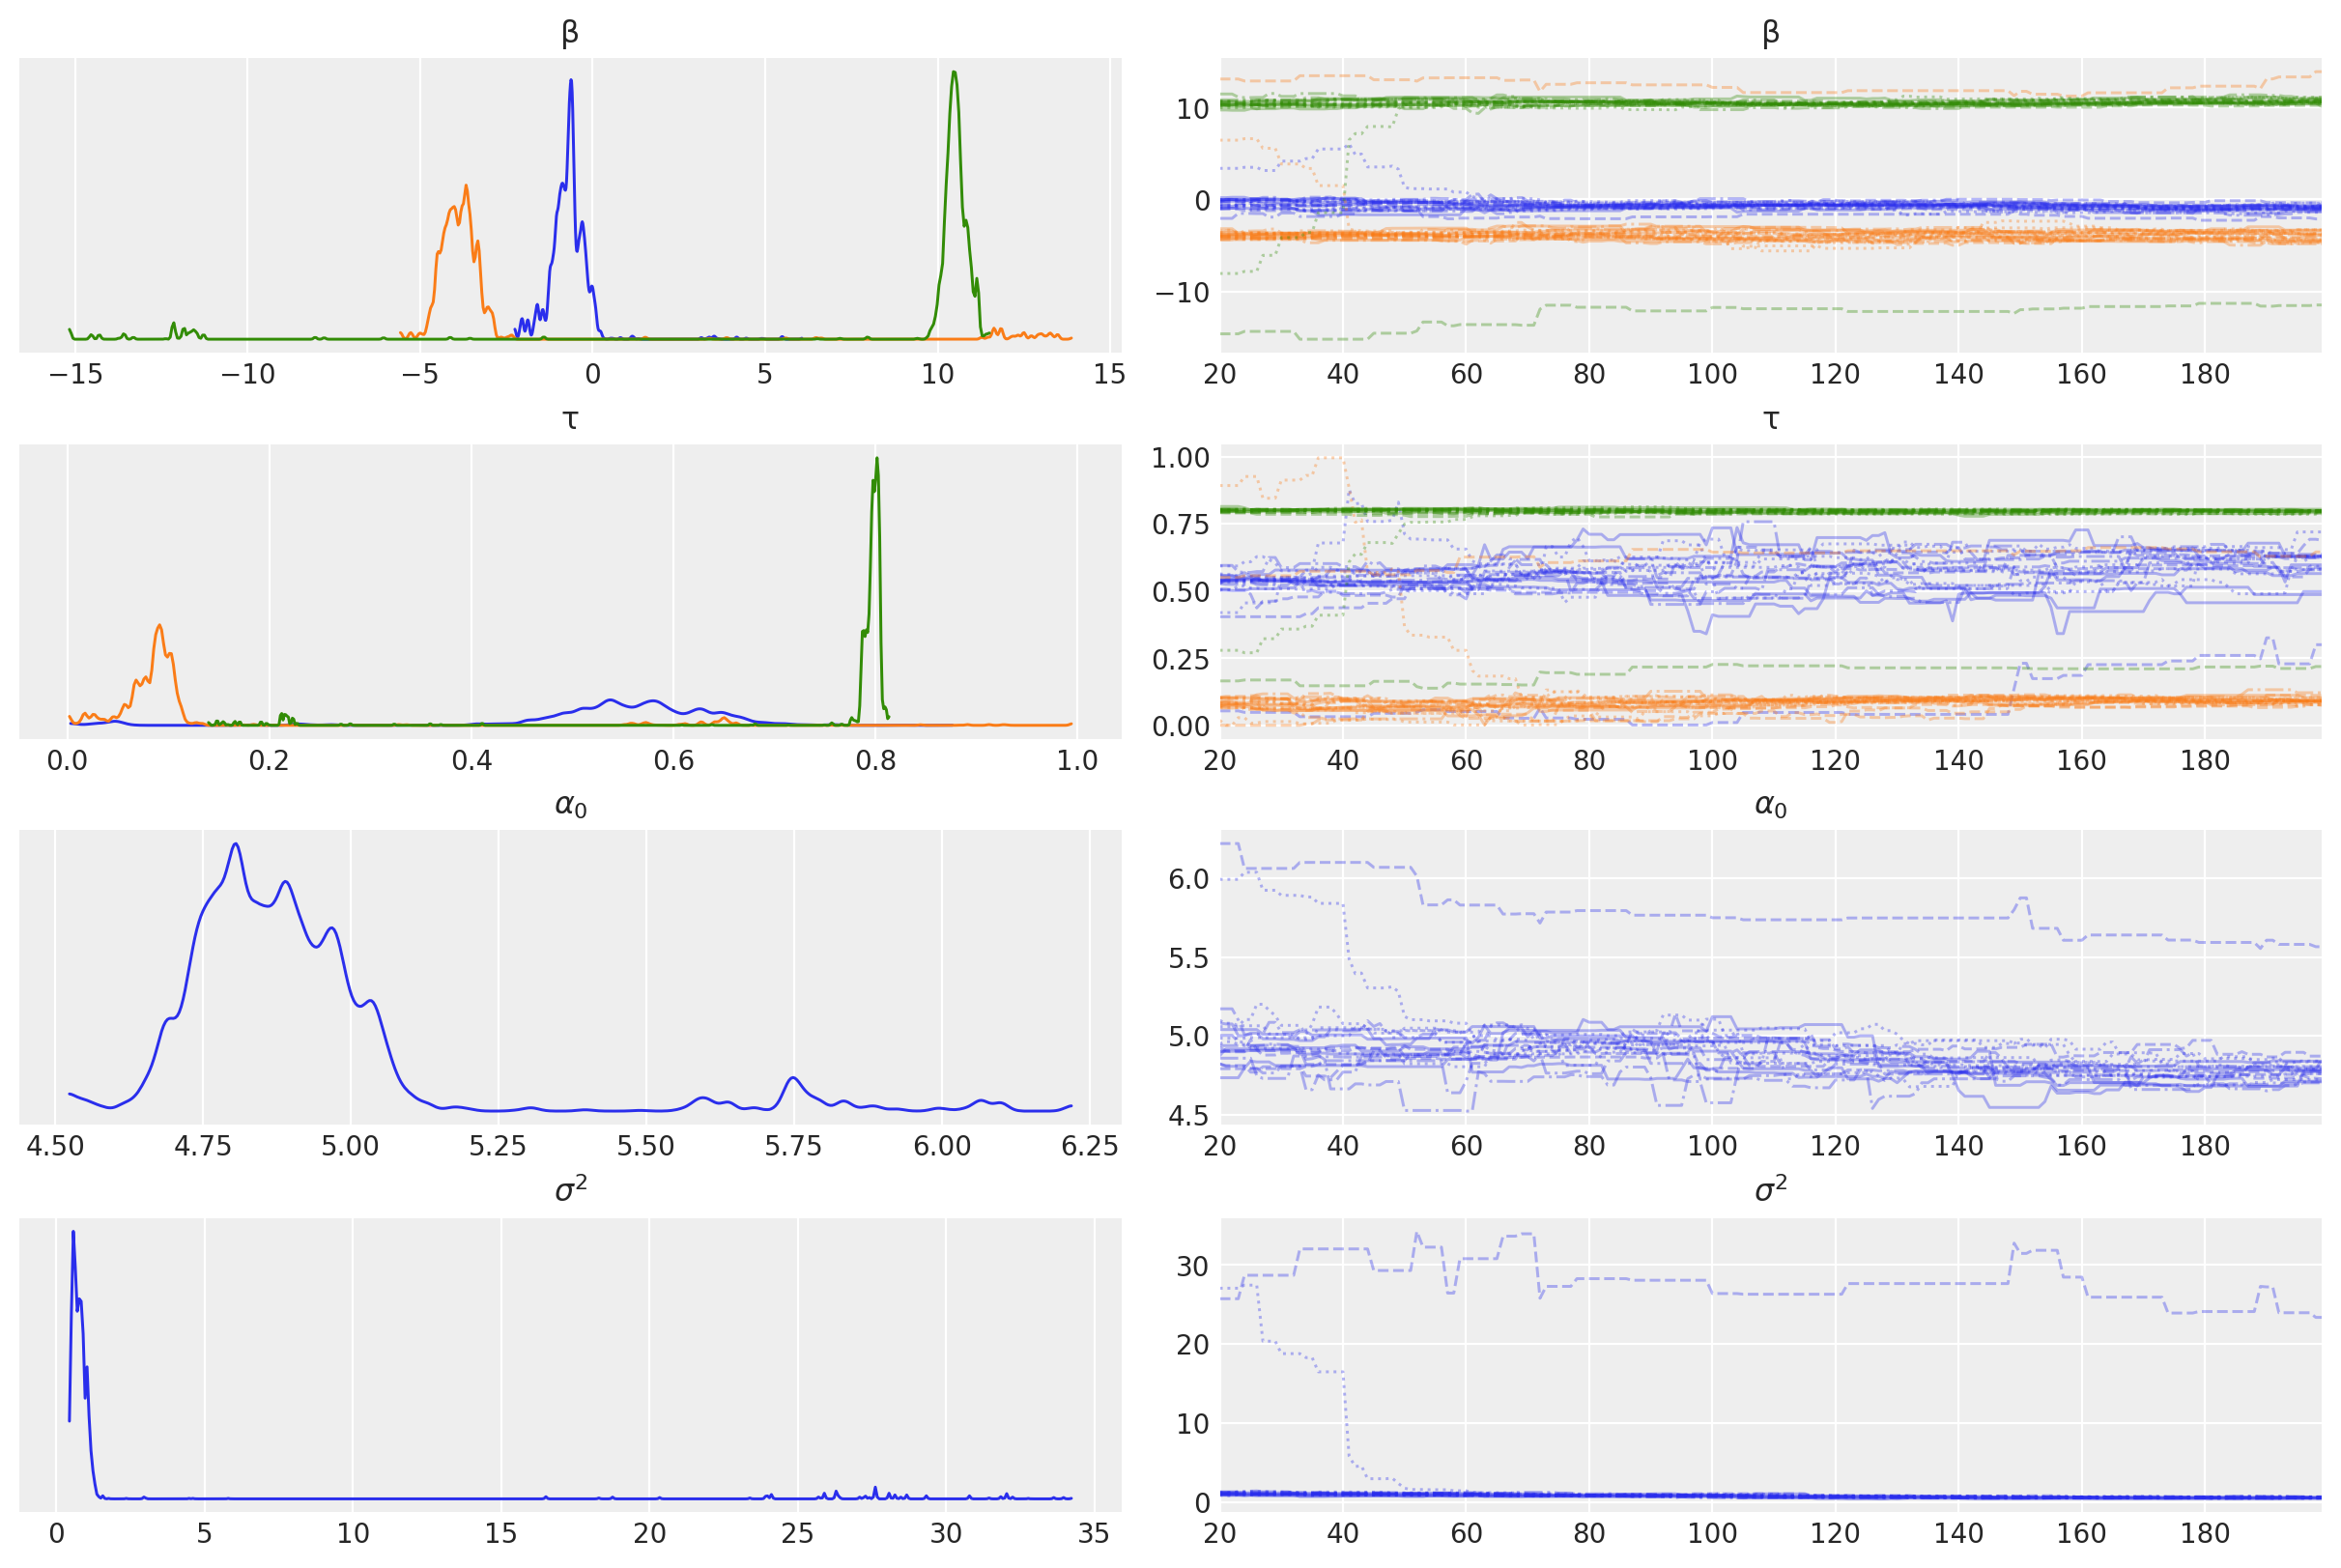

In [17]:
# -- Trace plot

az.plot_trace(
    idata_emcee,
    labeller=theta_labeller,
    combined=True,
    var_names=theta_names
)

print("Combined density and trace plot:")

Marginal posterior distributions:


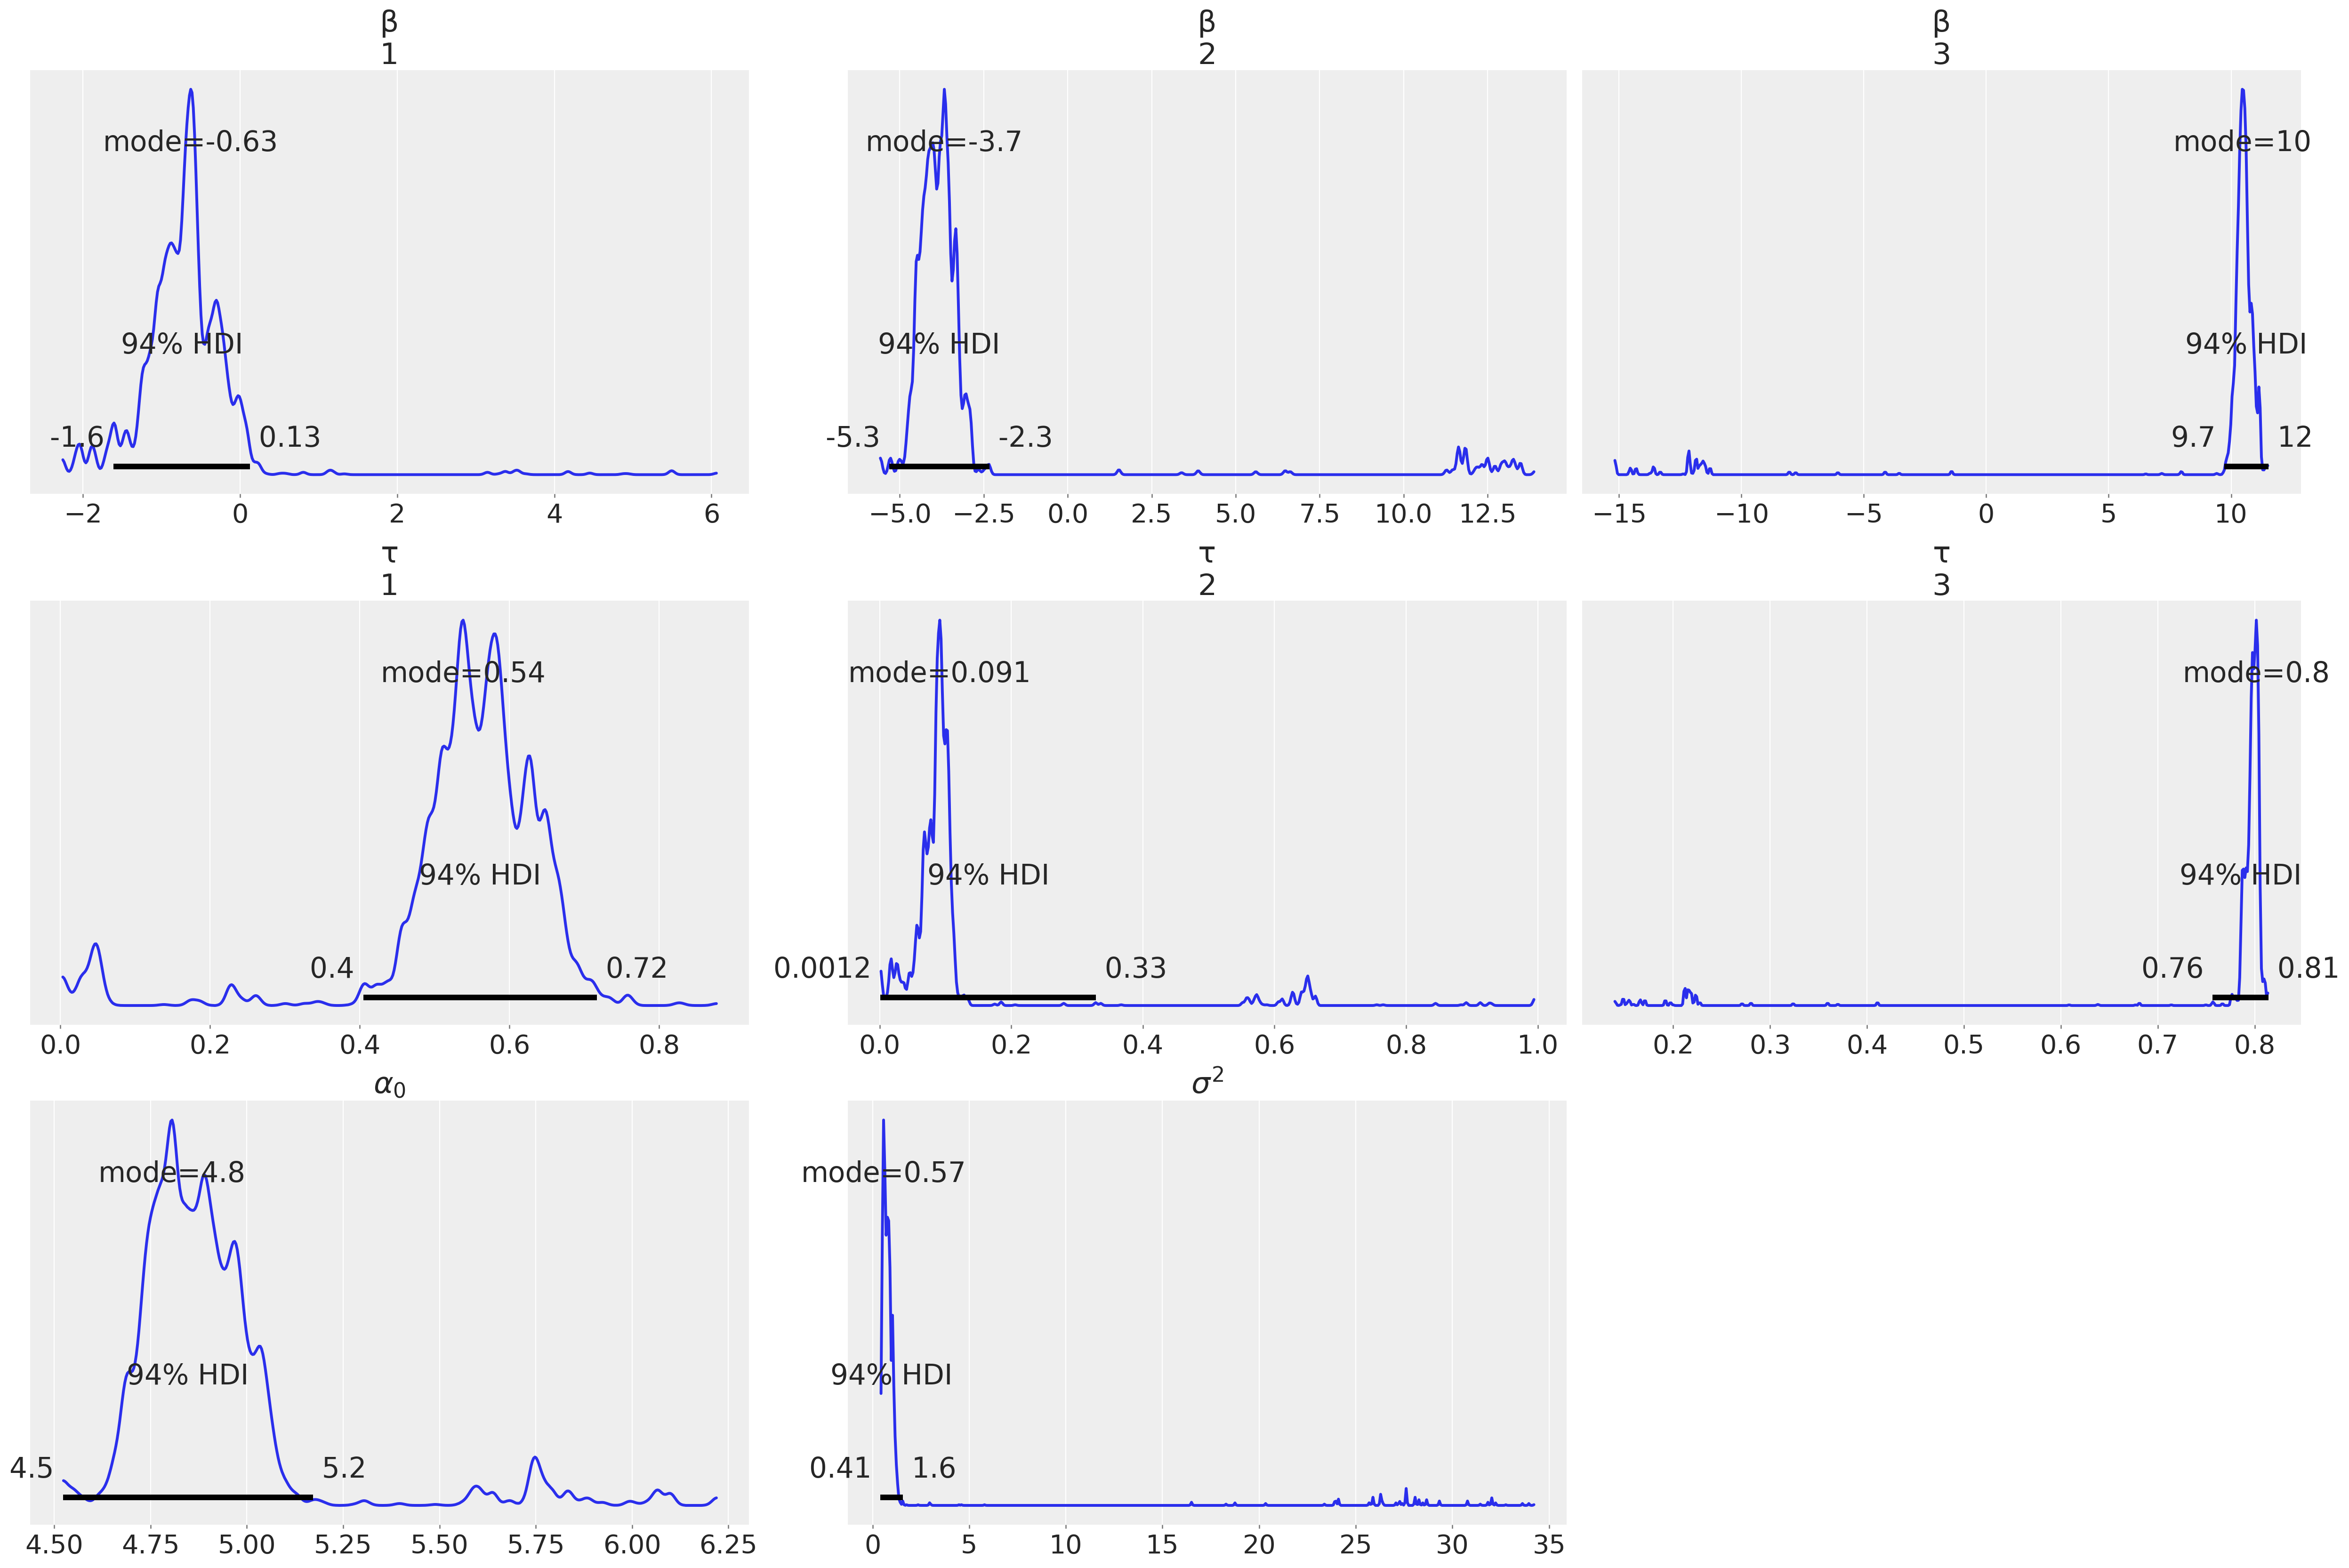

In [18]:
# -- Marginal posterior plot

plot_utils.plot_posterior(
    idata_emcee,
    theta_space,
    gridsize=(NROWS(theta_space.n_dim), NCOLS),
    textsize=20,
)

print("Marginal posterior distributions:")

We can perform a couple of visual posterior predictive checks. In particular:
    
- A plot of the distribution of $Y$ and the distribution of $\{Y^*_m\}_m$ (one for every sample $\theta_m$ of the chain), generated using the original traning data $X$.
- A plot of the distribution of $T(Y^*)$, where $T(x)=\bar x$. 

We also show the Bayesian p-value for several statistics, which is defined as $P(T(y^*)\leq T(y)\mid y)$, and is computed by simply measuring the proportion of generated samples $\{T(Y^*_m)\}_m$ that fall below the real value of the statistic. It is expected to be around $0.5$ when the model accurately represents the data.

bpv [T=min]: 0.031
bpv [T=max]: 0.881
bpv [T=median]: 0.000
bpv [T=mean]: 0.342
bpv [T=std]: 0.804


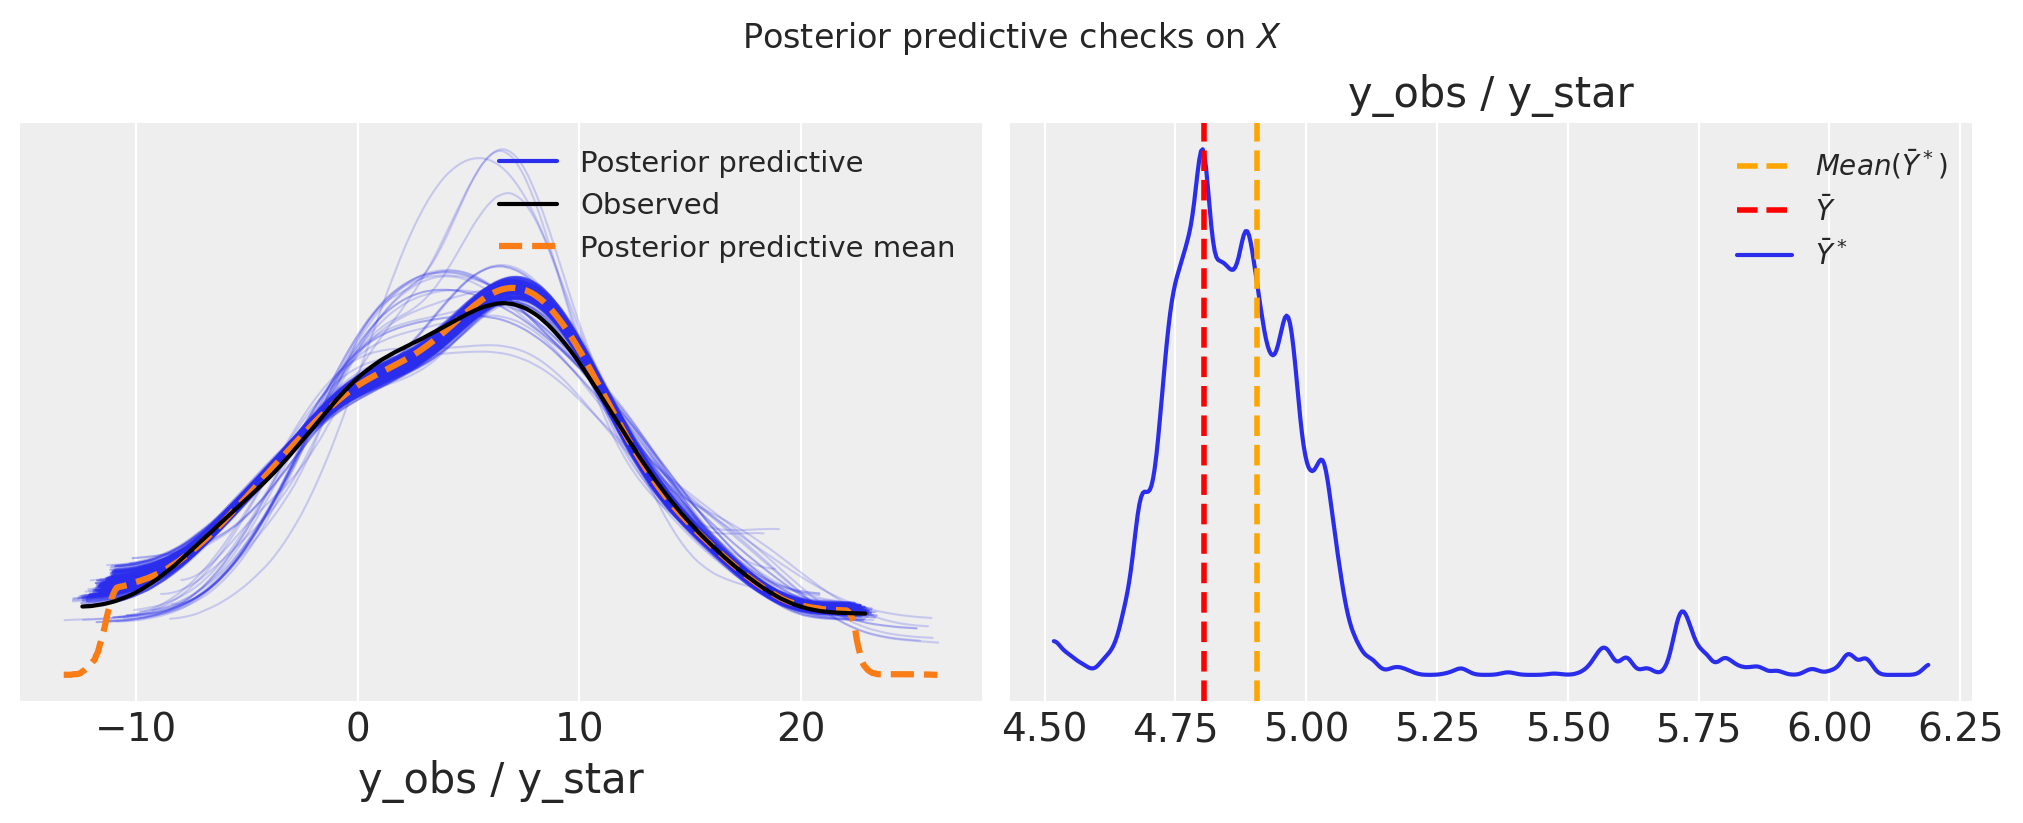

In [19]:
# -- Generate and plot posterior predictive checks from X

if "posterior_predictive" not in idata_emcee:
    pp = bayesian_model.generate_pp(
        idata_emcee, X, theta_space, rng=rng, 
        kind='linear', verbose=True)
    utils.pp_to_idata([pp], idata_emcee, ['y_star'], merge=True)
else:
    pp = idata_emcee.posterior_predictive['y_star'].to_numpy()

# Plot posterior predictive checks
plot_utils.plot_checks_linear(idata_emcee, test=False)

# Show Bayesian p-values
for name, stat in point_estimators_bpv:
    bpv = bayesian_model.bpv(pp, Y, stat)
    print(f"bpv [T={name}]: {bpv:.3f}")

Combined autocorrelation times:


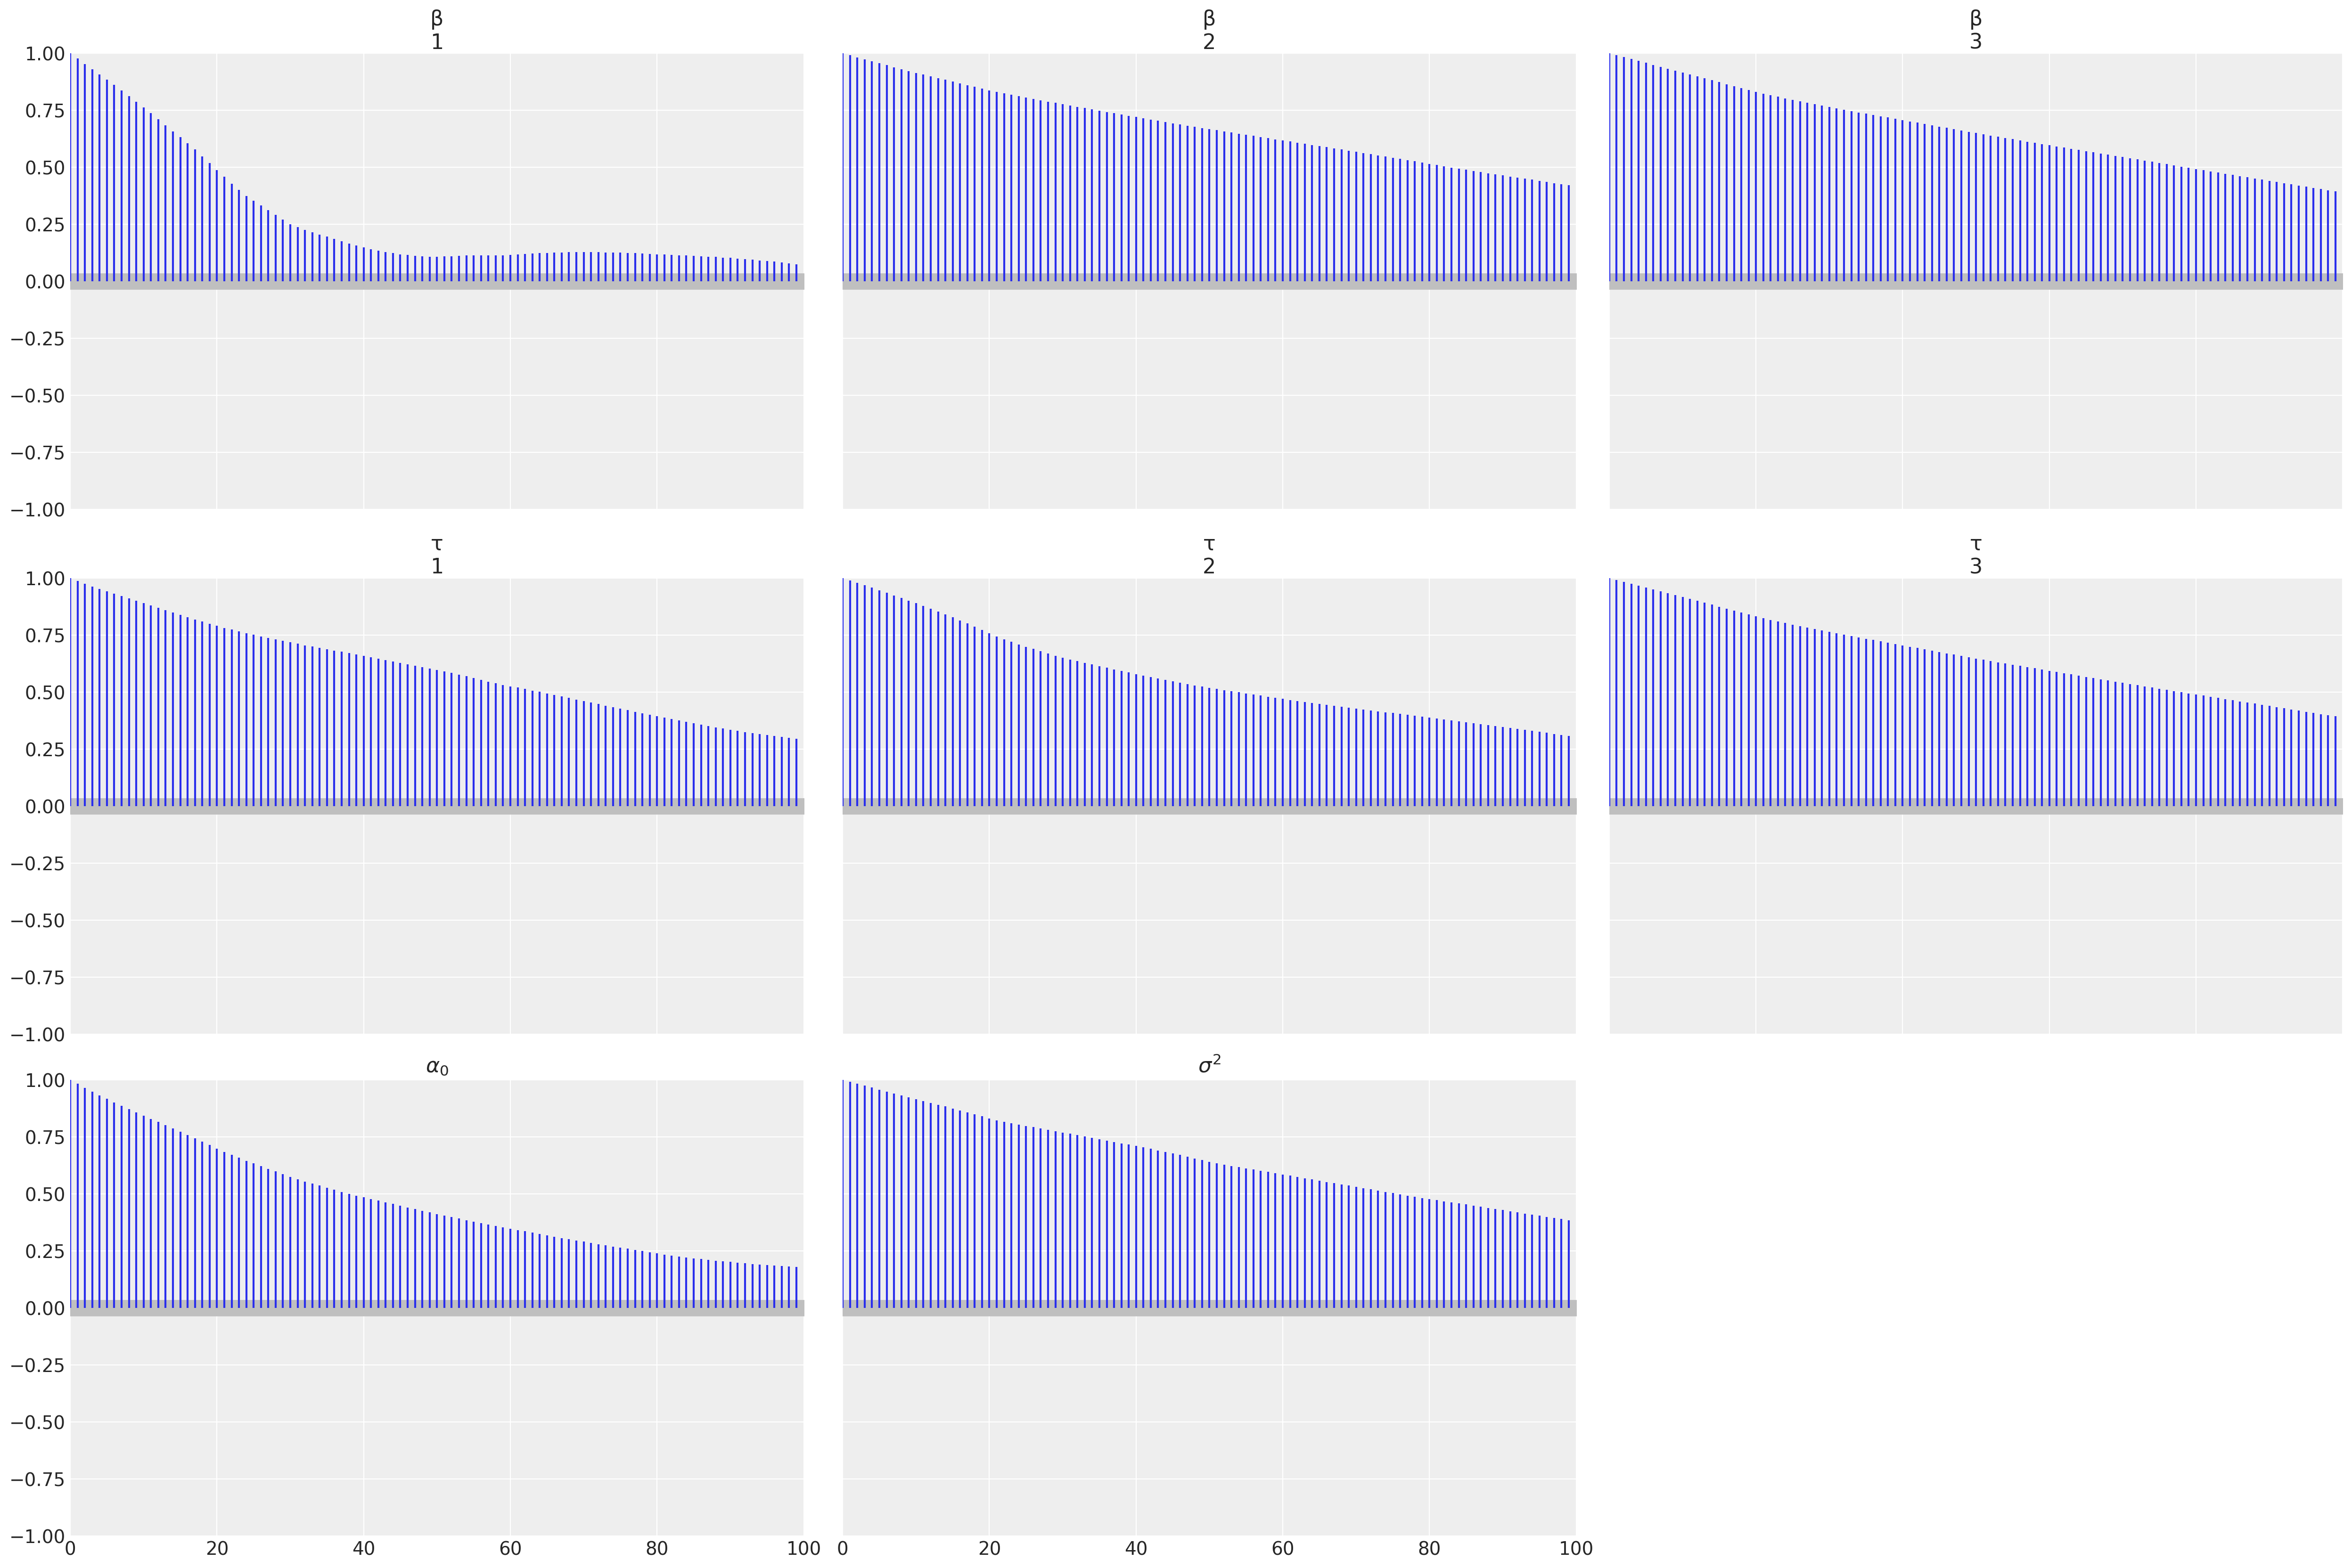

In [20]:
# -- Autocorrelation

plot_utils.plot_autocorr(
    idata_emcee,
    theta_space,
    gridsize=(NROWS(theta_space.n_dim), NCOLS)
)

print("Combined autocorrelation times:")

### Out-of-sample predictions

Generating posterior predictive samples...
bpv [T=min]: 0.385
bpv [T=max]: 0.412
bpv [T=median]: 0.880
bpv [T=mean]: 0.339
bpv [T=std]: 0.407


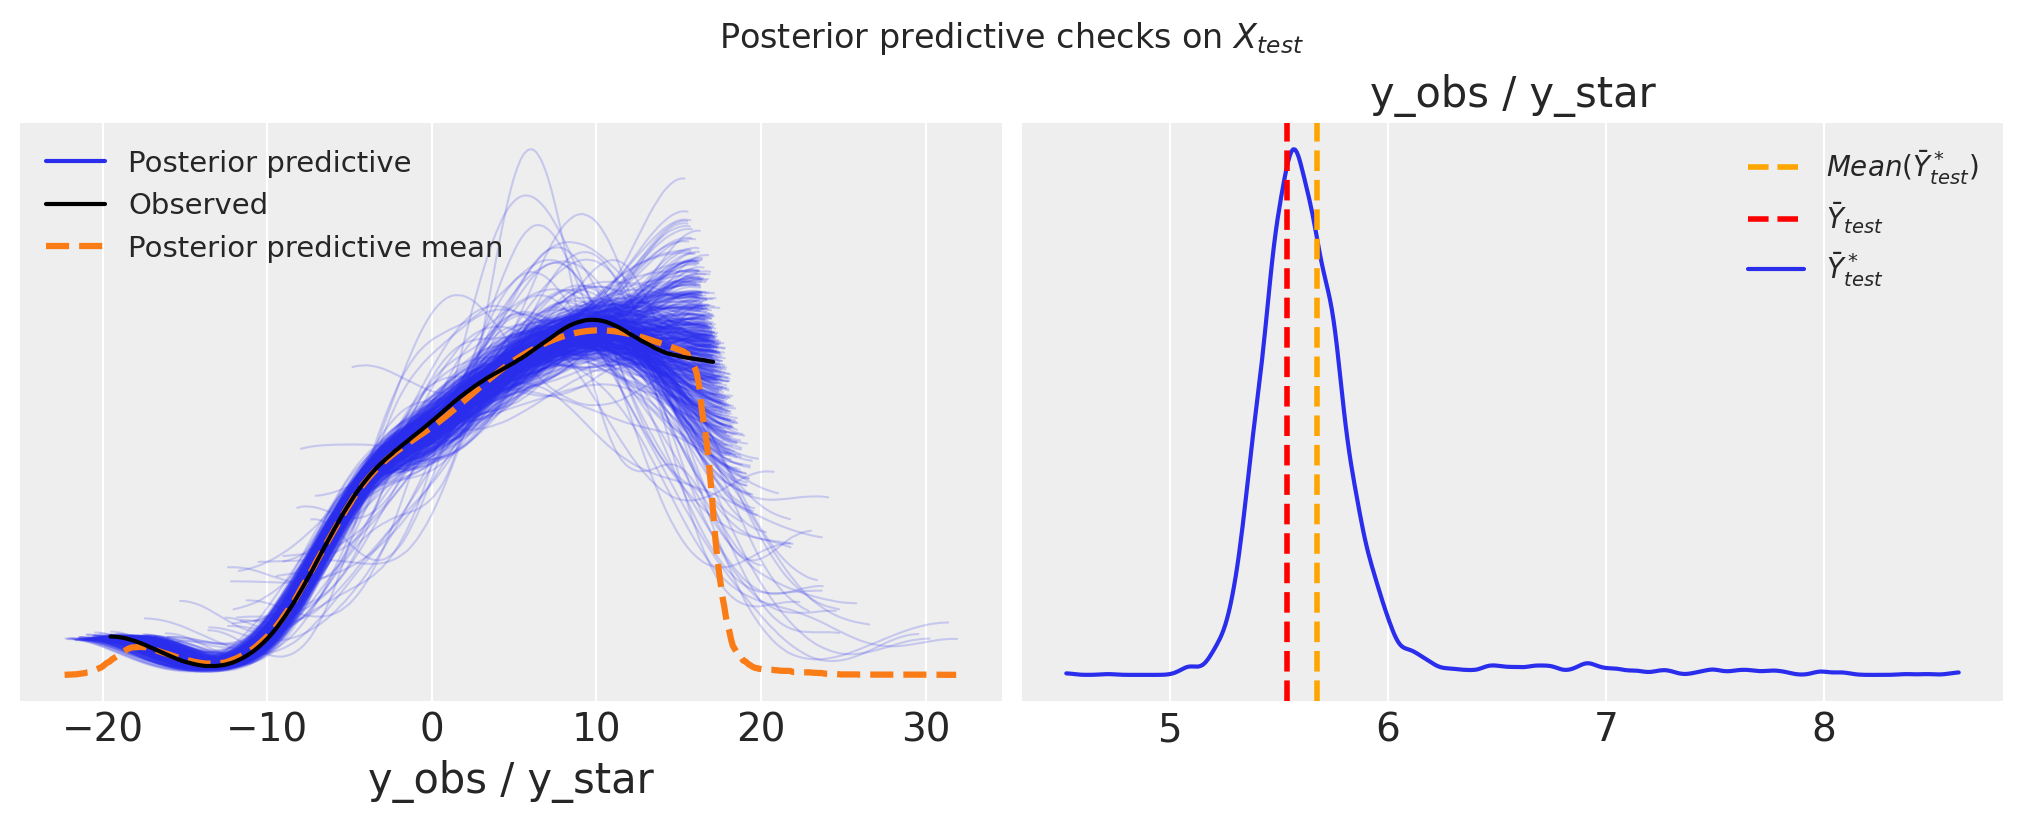

In [21]:
# -- Generate and plot posterior predictive checks from X_test

# Posterior predictive checks
pp_test = bayesian_model.generate_pp(
    idata_emcee,
    X_test,
    theta_space,
    rng=rng,
    kind='linear',
    verbose=True,
)
idata_pp_test = utils.pp_to_idata(
    [pp_test], idata_emcee, ['y_star'], y_obs=Y_test)

# Plot posterior predictive checks
plot_utils.plot_checks_linear(idata_pp_test, test=True)

# Show Bayesian p-values
for name, stat in point_estimators_bpv:
    bpv = bayesian_model.bpv(pp_test, Y_test, stat)
    print(f"bpv [T={name}]: {bpv:.3f}")

In [22]:
# -- Compute metrics using several point estimates

# Posterior mean estimate
Y_pred_pp = pp_test[:, ::thin_pp, :].mean(axis=(0, 1))
df_metrics_emcee = utils.linear_regression_metrics(
    Y_test,
    Y_pred_pp,
    reg_emcee.n_components("posterior_mean"),
    "emcee_posterior_mean"
)

# Point estimates
for pe in reg_emcee.default_point_estimates:
    Y_pred_pe = reg_emcee.predict(X_test, strategy=pe)
    df_metrics_emcee = utils.linear_regression_metrics(
        Y_test,
        Y_pred_pe,
        reg_emcee.n_components(pe),
        "emcee_" + pe,
        df=df_metrics_emcee,
    )

df_metrics_emcee.style.hide(axis="index")

In [23]:
# -- Test variable selection procedure

df_metrics_emcee_var_sel = None

for pe in reg_emcee.default_point_estimates:
    X_red = reg_emcee.transform(X, pe=pe)
    X_test_red = reg_emcee.transform(X_test, pe=pe)

    df_metrics_emcee_var_sel = utils.multiple_linear_regression_cv(
        X_red,
        Y,
        X_test_red,
        Y_test,
        folds,
        n_jobs=N_CORES,
        prefix="emcee",
        pe=pe,
        df=df_metrics_emcee_var_sel,
        random_state=SEED
    )

df_metrics_emcee_var_sel.style.hide(axis="index")

### Save & Load

This is only for testing purposes; in a production environment one should use the [Backends](https://emcee.readthedocs.io/en/stable/user/backends/) feature of *emcee*.

In [44]:
# -- Save

with open("emcee-linear.idata", 'wb') as file:
    pickle.dump(idata_emcee, file)

In [45]:
# -- Load

with open("emcee-linear.idata", 'rb') as file:
    idata_emcee = pickle.load(file)
    trace = idata_emcee.posterior.to_array().to_numpy().T
    trace_flat = trace.reshape(-1, trace.shape[-1])  # All chains combined

## The PyMC library

**TODO (v4)**

- Change imports pymc3 -> pymc; theano.tensor -> aesara.tensor
- Try beta = MvNormal
- Try symbolic shape (e.g. tau.shape == p)
- Measure execution times of new pm.sample_posterior_predictive (X should be MutableData (and changed for X_test) for ppc in test set).
- Si beta acaba siendo DensityDist, medir tiempos con y sin parámetros en beta_logp
- Definir adecuadamente los valores iniciales (initval) en p, para que haya al menos uno en cada cadena.
- Añadir random a beta para poder samplear de ella.
- Cambiar start=.. por initvals=... en pm.sample()
- Probar Sequential Monte Carlo
- Probar jax_sampling

In [24]:
from mcmc_sampler import BFLinearPymc
import pymc3 as pm

### Experiments

In [25]:
# -- Sampler parameters

n_chains = N_CORES
USE_NUTS = False

if USE_NUTS:
    n_samples = 500
    n_tune = 500
    step_fn = pm.NUTS
    step_kwargs = {"target_accept": 0.8}
else:
    n_samples = 5000
    n_tune = 1000
    step_fn = pm.Metropolis
    step_kwargs = {}

burn = 0
thin = 1
thin_pp = 5

FAST_RUN = True
COMPUTE_METRICS_FAST_RUN = True

In [26]:
# -- Run sampler

print(f"-- Running pymc sampler with {N_CORES} cores --")

reg_pymc = BFLinearPymc(
    theta_space,
    n_chains,
    n_samples,
    b0='mle',
    g=g,
    eta=eta,
    prior_p=prior_p,
    step_fn=step_fn,
    step_kwargs=step_kwargs,
    n_iter_warmup=n_tune,
    thin=thin,
    thin_pp=thin_pp,
    burn=burn,
    mle_method=mle_method,
    mle_strategy=mle_strategy,
    n_jobs=N_CORES,
    verbose=2,
    random_state=SEED
)

if FAST_RUN:
    df_metrics_pymc = utils.run_bayesian_model(
        reg_pymc,
        X,
        Y,
        X_test,
        Y_test,
        folds,
        n_jobs=N_CORES,
        kind='linear',
        prefix='pymc',
        compute_metrics=COMPUTE_METRICS_FAST_RUN,
        verbose=True,
        notebook=True,
        sort_by=-2,
        random_state=SEED,
    )
    if COMPUTE_MLE:
        df_metrics_pymc = pd.concat([df_metrics_pymc, df_metrics_mle])
    if FIT_SK:
        df_metrics_pymc = pd.concat([df_metrics_pymc, df_metrics_sk])

    df_metrics_pymc.sort_values(
        df_metrics_pymc.columns[-2],
        inplace=True
    )
    display(df_metrics_pymc.style.hide(axis="index"))
else:
    reg_pymc.fit(X, Y)
    print(f"Mean acceptance: {100*reg_pymc.mean_acceptance():.3f}%")

idata_pymc = reg_pymc.get_idata()

-- Running pymc sampler with 4 cores --
[BFLinearPymc] Computing MLE...


 /home/antcc/MCD/TFM/bayesian-functional-regression/venv-bfr-py39/lib/python3.9/site-packages/scipy/optimize/_numdiff.py:557: RuntimeWarning:invalid value encountered in subtract
Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>Metropolis: [β]
>Metropolis: [τ]
>Metropolis: [α0_and_LogSq σ2]


Sampling 4 chains for 1_000 tune and 5_000 draw iterations (4_000 + 20_000 draws total) took 19 seconds.
The estimated number of effective samples is smaller than 200 for some parameters.


[BFLinearPymc] Discarding the first 0 samples...
Mean acceptance: 18.730%


mean     sd  hdi_3%  hdi_97%    min     max  median    mode
β[1]        -1.095  0.279  -1.613   -0.584 -2.306  -0.193  -1.084  -1.041
β[2]        -4.262  0.377  -4.925   -3.557 -5.643  -2.856  -4.252  -4.241
β[3]        10.840  0.243  10.406   11.278  9.969  11.898  10.833  10.864
τ[1]         0.612  0.055   0.489    0.705  0.389   0.800   0.617   0.632
τ[2]         0.092  0.009   0.075    0.105  0.065   0.115   0.092   0.092
τ[3]         0.798  0.005   0.788    0.805  0.785   0.805   0.799   0.800
$\alpha_0$   4.805  0.065   4.683    4.926  4.571   5.042   4.805   4.800
$\sigma^2$   0.427  0.062   0.319    0.544  0.252   0.897   0.422   0.395


Computing metrics...

Generating posterior predictive samples...


### Analysis

Since the tuning iterations already serve as burn-in, we keep the whole trace. In addition, we could consider thinning the samples.

In [27]:
# -- Trace summary

reg_pymc.summary(stats='all')

mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
β[1]        -1.095  0.279  -1.613   -0.584      0.013    0.009     476.0   
β[2]        -4.262  0.377  -4.925   -3.557      0.018    0.013     434.0   
β[3]        10.840  0.243  10.406   11.278      0.013    0.009     339.0   
τ[1]         0.612  0.055   0.489    0.705      0.005    0.004     114.0   
τ[2]         0.092  0.009   0.075    0.105      0.000    0.000     512.0   
τ[3]         0.798  0.005   0.788    0.805      0.000    0.000     849.0   
$\alpha_0$   4.805  0.065   4.683    4.926      0.002    0.001    1530.0   
$\sigma^2$   0.427  0.062   0.319    0.544      0.002    0.001    1395.0   

            ess_tail  r_hat    min     max  median    mode  
β[1]           863.0   1.01 -2.306  -0.193  -1.084  -1.041  
β[2]           691.0   1.01 -5.643  -2.856  -4.252  -4.241  
β[3]           741.0   1.01  9.969  11.898  10.833  10.864  
τ[1]           176.0   1.04  0.389   0.800   0.617   0.632  
τ[2]           588.0   1.01  0.065   0.115   0.092   0.092  
τ[3]          1374.0   1.01  0.785   0.805   0.799   0.800  
$\alpha_0$    2040.0   1.00  4.571   5.042   4.805   4.800  
$\sigma^2$    1986.0   1.00  0.252   0.897   0.422   0.395

Combined density and trace plot:


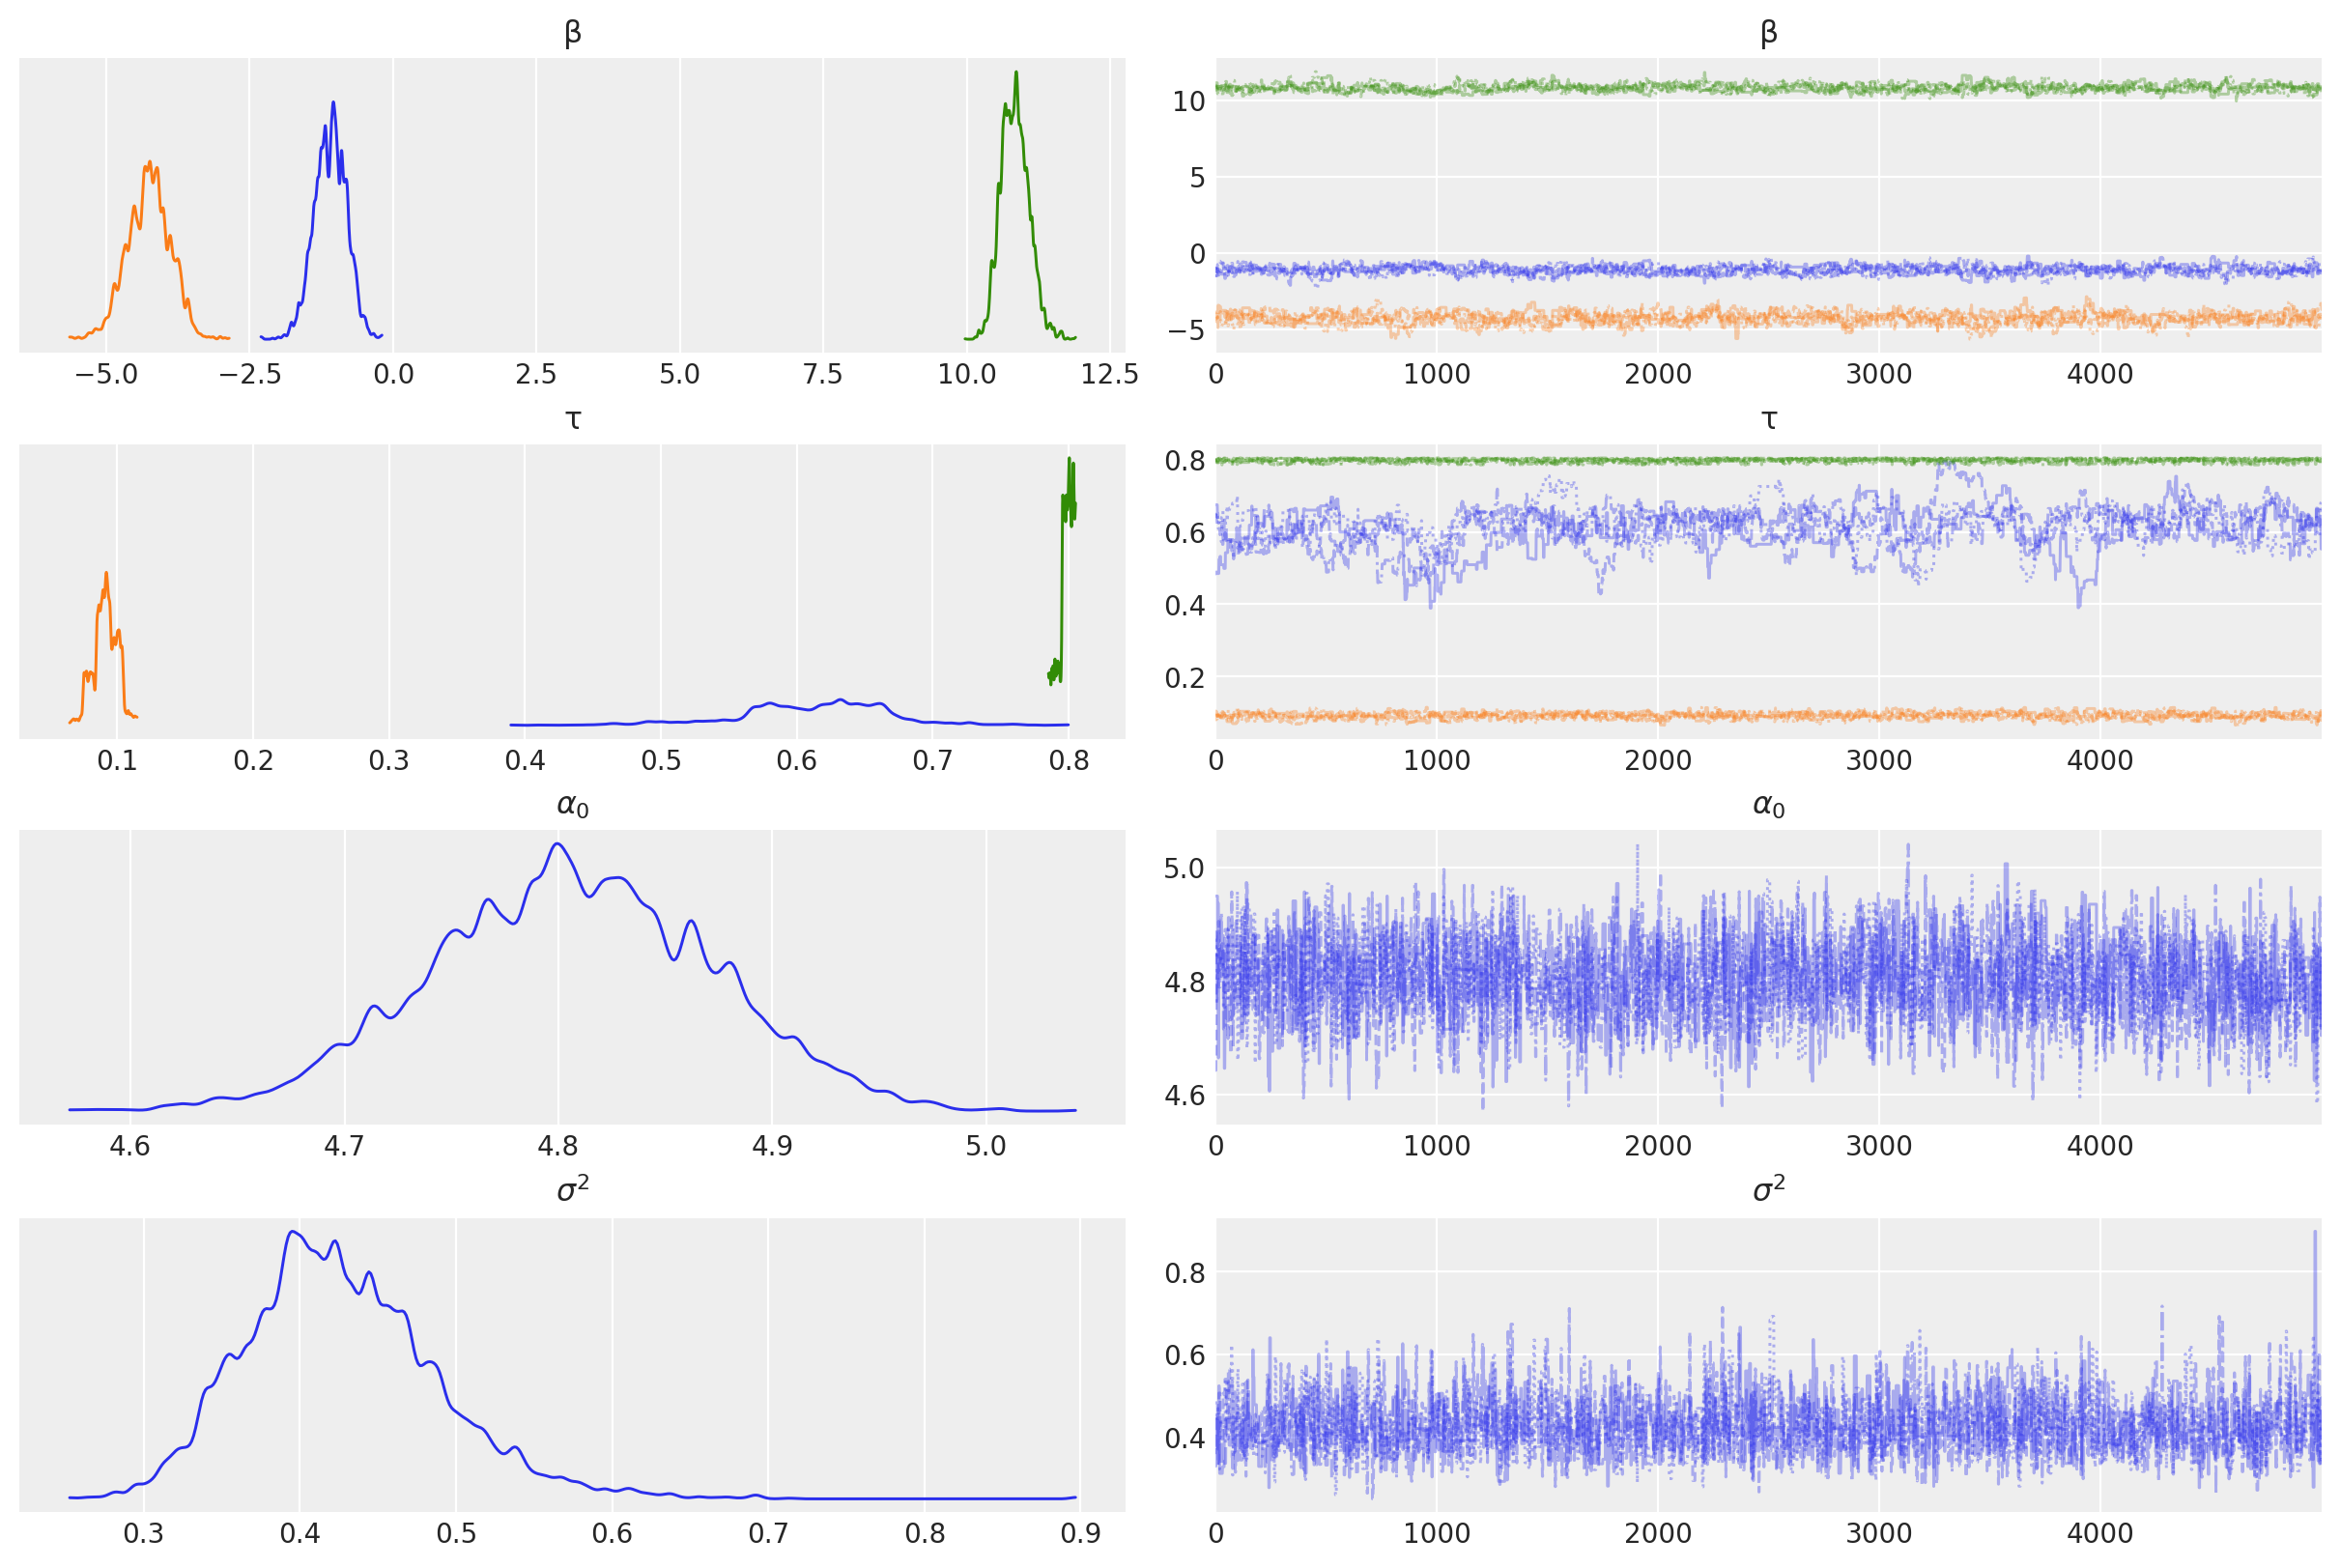

In [28]:
# -- Trace plot

az.plot_trace(
    idata_pymc,
    labeller=theta_labeller,
    combined=True,
    var_names=theta_names
)
print("Combined density and trace plot:")

Marginal posterior distributions:


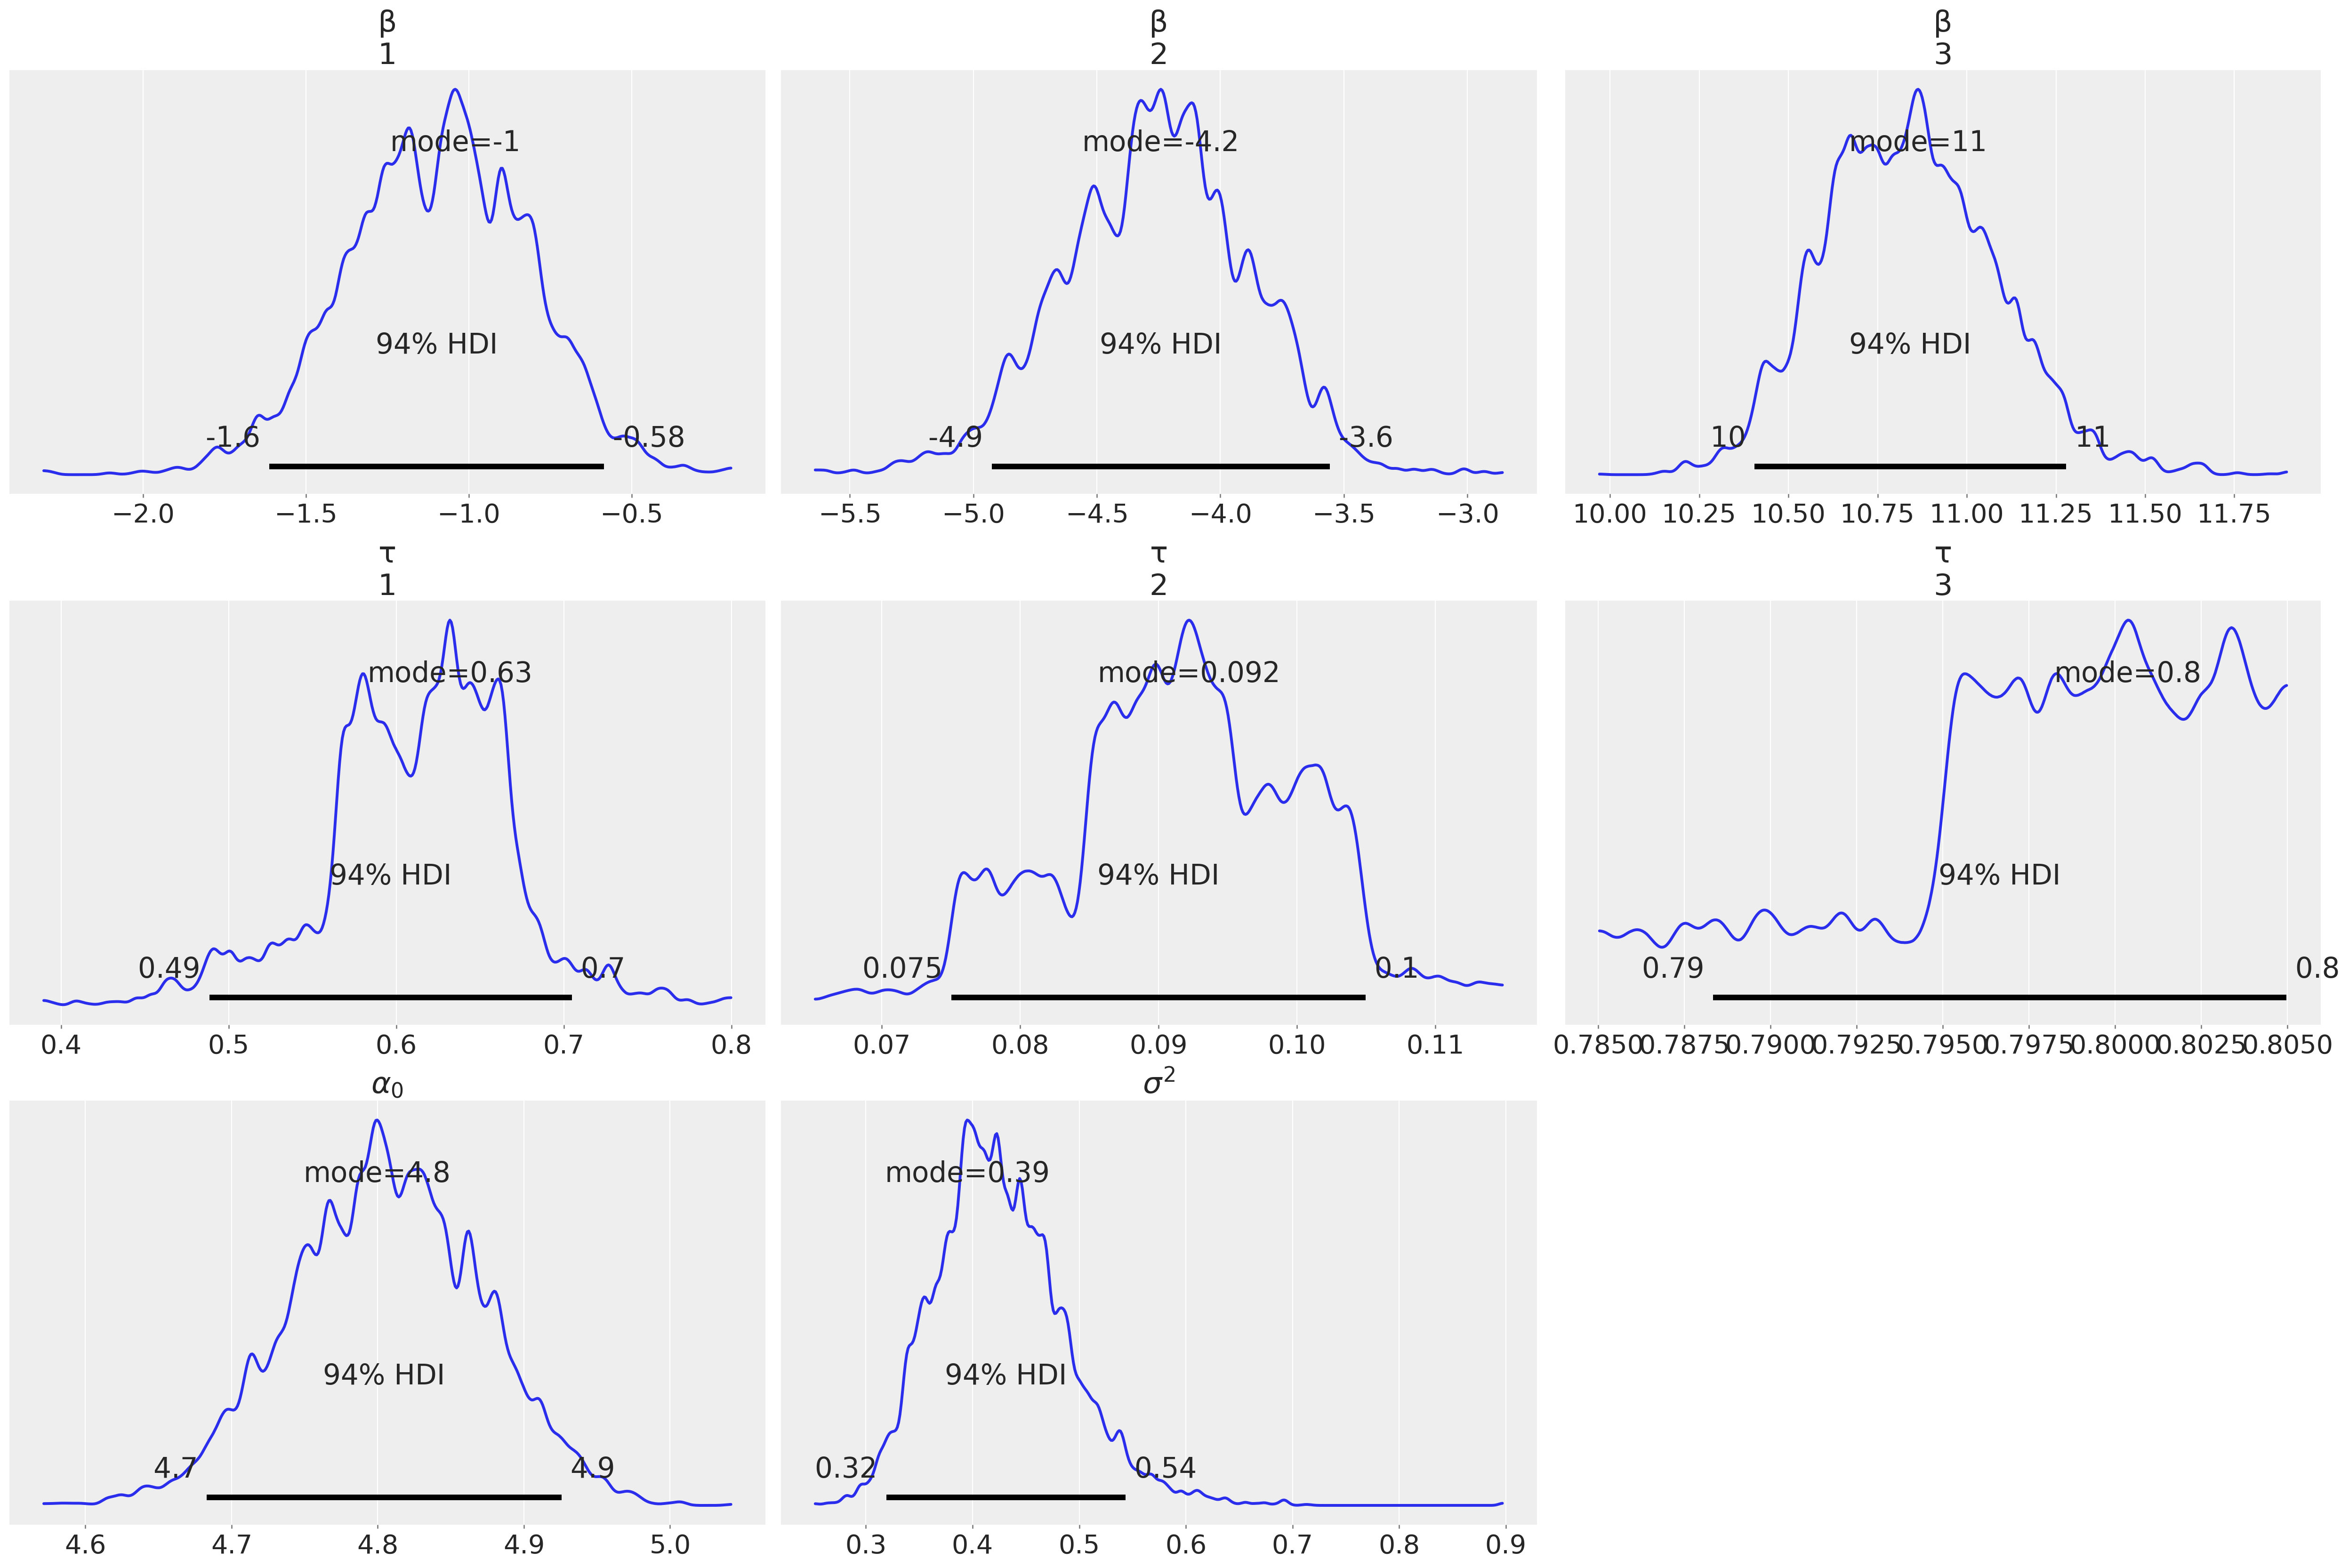

In [29]:
# -- Marginal posterior plot

plot_utils.plot_posterior(
    idata_pymc,
    theta_space,
    gridsize=(NROWS(theta_space.n_dim), NCOLS),
    textsize=20,
)

print("Marginal posterior distributions:")

Generating posterior predictive samples...
bpv [T=min]: 0.460
bpv [T=max]: 0.114
bpv [T=median]: 0.156
bpv [T=mean]: 0.492
bpv [T=std]: 0.550


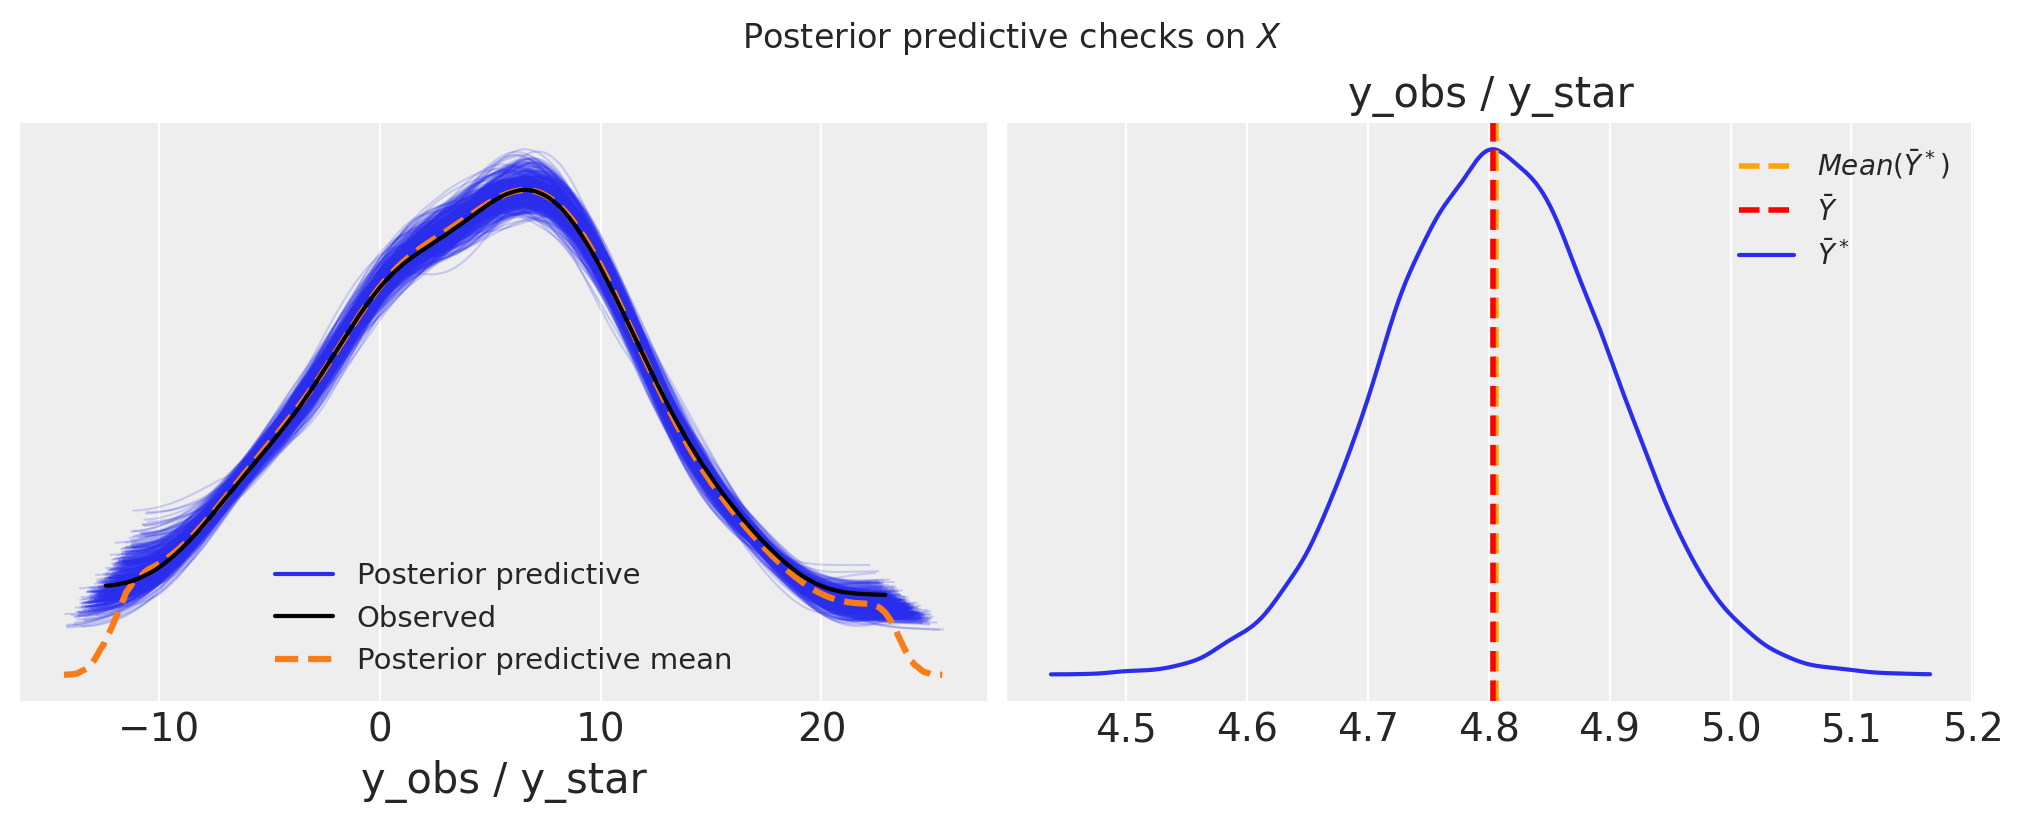

In [30]:
# -- Generate and plot posterior predictive checks from X

pp = bayesian_model.generate_pp(
    idata_pymc, X, theta_space, rng=rng, 
    kind='linear', verbose=True)
utils.pp_to_idata([pp], idata_pymc, ['y_star'], merge=True)

# Plot posterior predictive checks
plot_utils.plot_checks_linear(idata_pymc, test=False)

# Show Bayesian p-values
for name, stat in point_estimators_bpv:
    bpv = bayesian_model.bpv(pp, Y, stat)
    print(f"bpv [T={name}]: {bpv:.3f}")

Combined autocorrelation times:


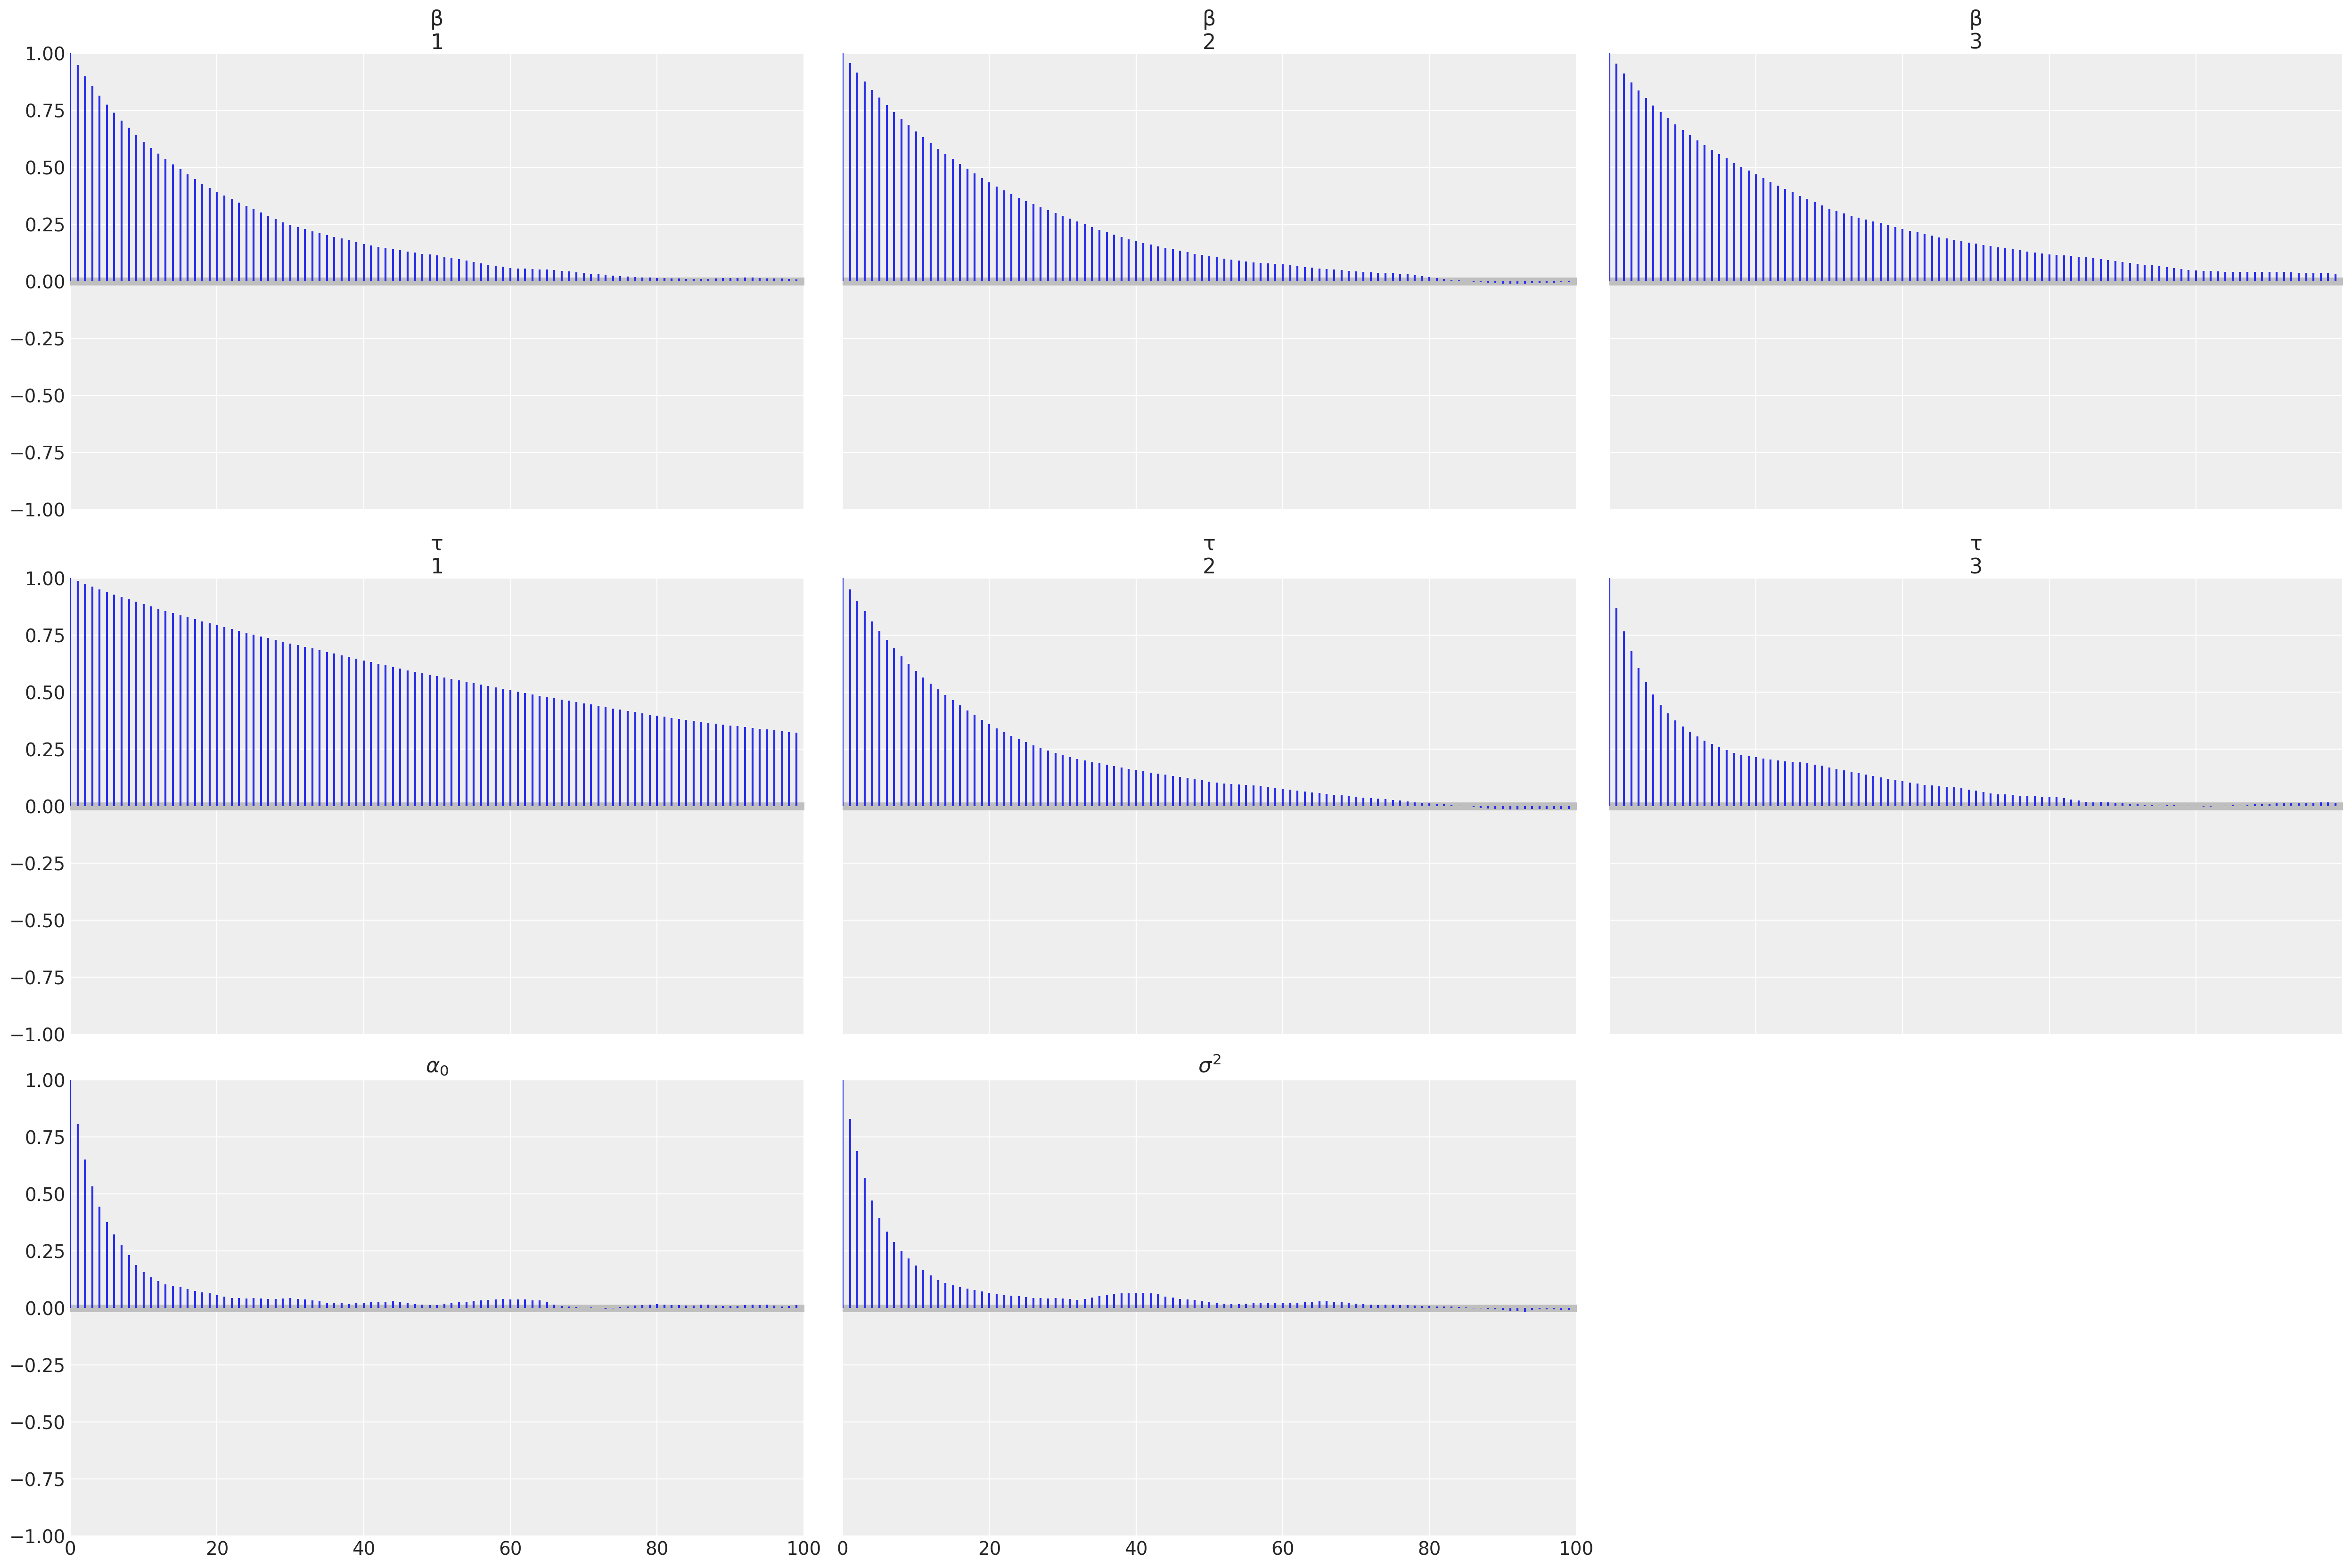

In [31]:
# -- Autocorrelation

plot_utils.plot_autocorr(
    idata_pymc,
    theta_space,
    gridsize=(NROWS(theta_space.n_dim), NCOLS)
)

print("Combined autocorrelation times:")

Graphical model:


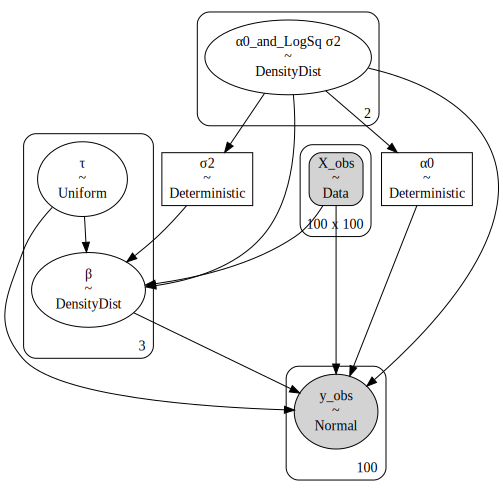

In [32]:
# -- Graphical model

print("Graphical model:")
reg_pymc.to_graphviz()

### Out-of-sample predictions

First we take a look at the distribution of predictions on a previously unseen dataset.

Generating posterior predictive samples...
bpv [T=min]: 0.338
bpv [T=max]: 0.733
bpv [T=median]: 0.953
bpv [T=mean]: 0.497
bpv [T=std]: 0.633


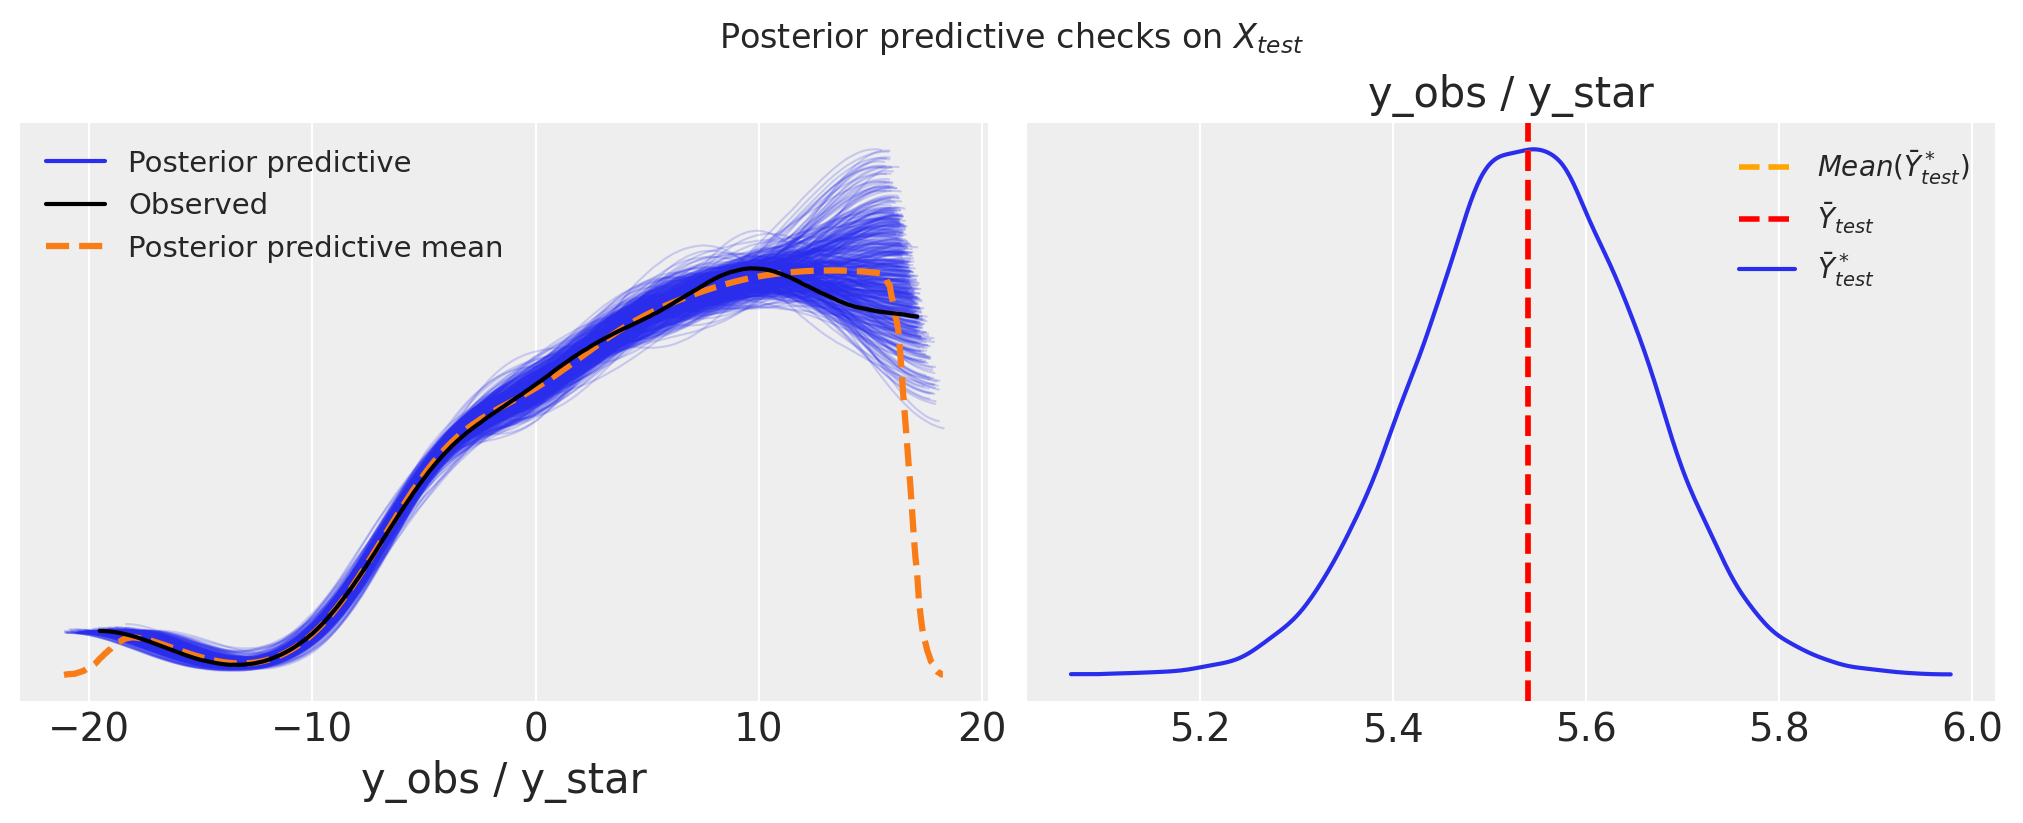

In [33]:
# -- Generate and plot posterior predictive checks from X_test

pp_test = bayesian_model.generate_pp(
    idata_pymc, X_test, theta_space, rng=rng, 
    kind='linear', verbose=True)
idata_pp_test = utils.pp_to_idata(
    [pp_test], idata_pymc, ['y_star'], y_obs=Y_test)

# Plot posterior predictive checks
plot_utils.plot_checks_linear(idata_pp_test, test=True)

# Show Bayesian p-values
for name, stat in point_estimators_bpv:
    bpv = bayesian_model.bpv(pp_test, Y_test, stat)
    print(f"bpv [T={name}]: {bpv:.3f}")

Next we look at the MSE when using several point-estimates for the parameters, as well as the mean of the posterior samples.

In [34]:
# -- Compute metrics using several point estimates

# Posterior mean estimate
Y_pred_pp = pp_test[:, ::thin_pp, :].mean(axis=(0, 1))
df_metrics_pymc = utils.linear_regression_metrics(
    Y_test,
    Y_pred_pp,
    reg_pymc.n_components("posterior_mean"),
    "pymc_posterior_mean"
)

# Point estimates
for pe in reg_pymc.default_point_estimates:
    Y_pred_pe = reg_pymc.predict(X_test, strategy=pe)
    df_metrics_pymc = utils.linear_regression_metrics(
        Y_test,
        Y_pred_pe,
        reg_pymc.n_components(pe),
        "pymc_" + pe,
        df=df_metrics_pymc,
    )

df_metrics_pymc.style.hide(axis="index")

In [35]:
# -- Test variable selection procedure

df_metrics_pymc_var_sel = None

for pe in reg_pymc.default_point_estimates:
    X_red = reg_pymc.transform(X, pe=pe)
    X_test_red = reg_pymc.transform(X_test, pe=pe)

    df_metrics_pymc_var_sel = utils.multiple_linear_regression_cv(
        X_red,
        Y,
        X_test_red,
        Y_test,
        folds,
        n_jobs=N_CORES,
        prefix="pymc",
        pe=pe,
        df=df_metrics_pymc_var_sel,
        random_state=SEED,
    )

df_metrics_pymc_var_sel.style.hide(axis="index")

### Save & Load

In [42]:
# -- Save

_ = idata_pymc.to_netcdf("pymc-linear.nc")

In [43]:
# -- Load

idata_pymc = az.from_netcdf("pymc-linear.nc")

## Notebook metadata

In [36]:
%load_ext watermark
%watermark -n -u -v -iv -w

Last updated: Fri Jun 03 2022

Python implementation: CPython
Python version       : 3.9.13
IPython version      : 7.30.1

arviz     : 0.12.1
skfda     : 0.0
numpy     : 1.22.1
pandas    : 1.4.2
emcee     : 3.1.2
autopep8  : 1.6.0
pymc3     : 3.11.5
json      : 2.0.9
matplotlib: 3.5.2
sys       : 3.9.13 (main, May 19 2022, 08:22:48) 
[GCC 12.1.0]

Watermark: 2.2.0

